In [42]:
import os
import pandas as pd

# Define new folder paths
base_folder = "C:/FRR40/rat25-main/sample_data"
detections_folder = os.path.join(base_folder, "detections")
objects_folder = os.path.join(base_folder, "objects")
ego_motion_folder = os.path.join(base_folder, "ego_motion")
processed_folder = os.path.join(base_folder, "processed")  # For saving new processed files
os.makedirs(processed_folder, exist_ok=True)

# Columns to retain
detections_columns = [
    "timestamp", "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity", "radialVelocityDomainMax"
]
objects_columns = [
    "timestamp", "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "status_measurement", "status_movement", "overdrivable", "underdrivable",
    "header.origin.x", "header.origin.y", "header.origin.z",
    "header.origin.roll", "header.origin.pitch", "header.origin.yaw", "reference_point"
]
ego_motion_columns = [
    "timestamp", "RotationRates.yawRateVehicleBody.value", "Velocity.SpeedCog.SpeedCog"
]

# Function to filter files
def filter_files(folder, columns_to_keep, output_subfolder):
    output_path = os.path.join(processed_folder, output_subfolder)
    os.makedirs(output_path, exist_ok=True)
    filtered_data = {}

    files = sorted([f for f in os.listdir(folder) if f.endswith(".p")])
    for file in files:
        file_path = os.path.join(folder, file)
        print(f"Processing file: {file}")
        
        # Load data
        data = pd.read_pickle(file_path)
        
        # Filter relevant columns
        filtered_df = data[columns_to_keep]
        filtered_data[file] = filtered_df
        
        # Save filtered file
        save_path = os.path.join(output_path, file)
        filtered_df.to_pickle(save_path)
        print(f"Filtered data saved to: {save_path}")

    return filtered_data

# Filter detections, objects, and ego motion files
filtered_detections = filter_files(detections_folder, detections_columns, "filtered_detections")
filtered_objects = filter_files(objects_folder, objects_columns, "filtered_objects")
filtered_ego_motion = filter_files(ego_motion_folder, ego_motion_columns, "filtered_ego_motion")

# Verify the results
print("\nFiltered files are saved in the 'processed' folder.")


Processing file: frr40_detections_0.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_detections\frr40_detections_0.p
Processing file: frr40_detections_1.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_detections\frr40_detections_1.p
Processing file: frr40_detections_2.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_detections\frr40_detections_2.p
Processing file: frr40_detections_3.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_detections\frr40_detections_3.p
Processing file: frr40_objects_0.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_objects\frr40_objects_0.p
Processing file: frr40_objects_1.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_objects\frr40_objects_1.p
Processing file: frr40_objects_2.p
Filtered data saved to: C:/FRR40/rat25-main/sample_data\processed\filtered_objects\frr40_objects_2.p
Processing f

In [43]:
from datetime import timedelta

# Define the folder paths
filtered_detections_folder = os.path.join(processed_folder, "filtered_detections")
filtered_objects_folder = os.path.join(processed_folder, "filtered_objects")
filtered_ego_motion_folder = os.path.join(processed_folder, "filtered_ego_motion")
combined_data_folder = os.path.join(processed_folder, "combined_data")
os.makedirs(combined_data_folder, exist_ok=True)

# Function to find the closest timestamp in ego motion
def find_closest_timestamp(timestamp, ego_motion_df):
    closest_row = ego_motion_df.iloc[(ego_motion_df['timestamp'] - timestamp).abs().argsort()[:1]]
    return closest_row.iloc[0]

# Function to combine data
def combine_dataframes(detections_folder, objects_folder, ego_motion_folder, output_folder):
    combined_data = []

    # Load filtered files
    detection_files = sorted([f for f in os.listdir(detections_folder) if f.endswith(".p")])
    object_files = sorted([f for f in os.listdir(objects_folder) if f.endswith(".p")])
    ego_motion_files = sorted([f for f in os.listdir(ego_motion_folder) if f.endswith(".p")])

    # Ensure matching file pairs
    for det_file, obj_file in zip(detection_files, object_files):
        print(f"Combining {det_file} and {obj_file}...")

        # Load detections and objects
        det_path = os.path.join(detections_folder, det_file)
        obj_path = os.path.join(objects_folder, obj_file)
        detections_df = pd.read_pickle(det_path)
        objects_df = pd.read_pickle(obj_path)

        # Merge detections and objects on timestamp
        merged_df = pd.merge(detections_df, objects_df, on="timestamp", suffixes=("_det", "_obj"))

        # Find and match ego motion data
        closest_ego_motion = []
        for _, row in merged_df.iterrows():
            timestamp = row["timestamp"]
            ego_motion_data = None

            for ego_file in ego_motion_files:
                ego_path = os.path.join(ego_motion_folder, ego_file)
                ego_motion_df = pd.read_pickle(ego_path)

                try:
                    closest_row = find_closest_timestamp(timestamp, ego_motion_df)
                    ego_motion_data = {
                        "yaw_rate": closest_row["RotationRates.yawRateVehicleBody.value"],
                        "ego_speed": closest_row["Velocity.SpeedCog.SpeedCog"]
                    }
                    break
                except Exception as e:
                    print(f"No matching ego motion data for timestamp {timestamp}: {e}")

            closest_ego_motion.append(ego_motion_data)

        # Add ego motion data to the merged dataframe
        ego_motion_df = pd.DataFrame(closest_ego_motion)
        merged_df = pd.concat([merged_df, ego_motion_df.reset_index(drop=True)], axis=1)

        # Save the combined file
        save_path = os.path.join(output_folder, f"combined_{det_file}")
        merged_df.to_pickle(save_path)
        combined_data.append(merged_df)
        print(f"Combined data saved to: {save_path}")

    return combined_data

# Combine dataframes
final_combined_data = combine_dataframes(
    filtered_detections_folder,
    filtered_objects_folder,
    filtered_ego_motion_folder,
    combined_data_folder
)

# Verify combined data
print(f"\nCombined data saved in: {combined_data_folder}")


Combining frr40_detections_0.p and frr40_objects_0.p...
Combined data saved to: C:/FRR40/rat25-main/sample_data\processed\combined_data\combined_frr40_detections_0.p
Combining frr40_detections_1.p and frr40_objects_1.p...
Combined data saved to: C:/FRR40/rat25-main/sample_data\processed\combined_data\combined_frr40_detections_1.p
Combining frr40_detections_2.p and frr40_objects_2.p...
Combined data saved to: C:/FRR40/rat25-main/sample_data\processed\combined_data\combined_frr40_detections_2.p
Combining frr40_detections_3.p and frr40_objects_3.p...
Combined data saved to: C:/FRR40/rat25-main/sample_data\processed\combined_data\combined_frr40_detections_3.p

Combined data saved in: C:/FRR40/rat25-main/sample_data\processed\combined_data


In [44]:
import os
import pandas as pd

def replace_invalid_objects_with_zero(data, object_columns):
    """
    Replaces invalid objects in specified columns with zeros based on the condition:
    overdrivable + underdrivable > 50. Handles rows with inconsistent data.
    """
    cleaned_data = data.copy()

    for idx, row in cleaned_data.iterrows():
        try:
            # Check if all object_columns have consistent lengths
            lengths = [len(row[col]) for col in object_columns if col in row and isinstance(row[col], list)]
            if len(set(lengths)) > 1:
                print(f"Row {idx} has inconsistent lengths: {lengths}. Skipping.")
                continue

            # Identify invalid indices based on the condition
            invalid_indices = [
                i for i in range(len(row["overdrivable"]))
                if row["overdrivable"][i] + row["underdrivable"][i] > 50
            ]

            # Replace invalid indices with zero in object-level columns
            for col in object_columns:
                if col in row and isinstance(row[col], list):
                    updated_values = row[col]
                    for i in invalid_indices:
                        if i < len(updated_values):  # Ensure the index is valid
                            if isinstance(updated_values[i], (int, float)):
                                updated_values[i] = 0  # Replace numerical values with 0
                            elif isinstance(updated_values[i], tuple):
                                updated_values[i] = (None, None)  # Replace tuples with (None, None)
                            elif isinstance(updated_values[i], list):
                                updated_values[i] = [0] * len(updated_values[i])  # Replace list values with [0, 0, ...]
                            else:
                                updated_values[i] = 0  # Replace other values with 0
                    cleaned_data.at[idx, col] = updated_values

        except Exception as e:
            print(f"Error processing row {idx}: {e}")

    print("Invalid objects replaced with zero.")
    return cleaned_data


# Path to the folder containing the combined data
folder_path = "C:\\FRR40\\rat25-main\\sample_data\\processed\\combined_data"

# Specify files to process
files_to_process = [
    "combined_frr40_detections_0.p",
    "combined_frr40_detections_1.p"
]

# Specify the object-level columns to process
object_columns = [
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "status_measurement", "status_movement", "overdrivable", "underdrivable",
    "radialVelocity", "angleElevation", "angleAzimuth", "distance", "rcs"
]

# Process each file
for file in files_to_process:
    file_path = os.path.join(folder_path, file)
    print(f"Processing file: {file}")

    # Load the data
    data = pd.read_pickle(file_path)

    # Replace invalid objects with zero
    cleaned_data = replace_invalid_objects_with_zero(data, object_columns)

    # Save the cleaned data
    save_path = os.path.join(folder_path, f"zeroed_{file}")
    cleaned_data.to_pickle(save_path)
    print(f"Cleaned data saved to: {save_path}")


Processing file: combined_frr40_detections_0.p
Invalid objects replaced with zero.
Cleaned data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\zeroed_combined_frr40_detections_0.p
Processing file: combined_frr40_detections_1.p
Invalid objects replaced with zero.
Cleaned data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\zeroed_combined_frr40_detections_1.p


In [45]:
import os
import pandas as pd
import numpy as np

def compare_row_lengths(original_file, cleaned_file, columns_to_check, rows_to_check=5):
    """
    Compares the lengths of rows for specified columns between original and cleaned files.
    Handles numpy.ndarray specifically for length checking.
    """
    original_data = pd.read_pickle(original_file)
    cleaned_data = pd.read_pickle(cleaned_file)

    print(f"\n--- Comparing Row Lengths for File: {os.path.basename(original_file)} ---")

    for idx in range(min(rows_to_check, len(original_data))):
        print(f"\nRow {idx} Lengths:")
        for col in columns_to_check:
            if col in original_data.columns and col in cleaned_data.columns:
                orig_values = original_data.iloc[idx][col]
                clean_values = cleaned_data.iloc[idx][col]

                # Check if both original and cleaned values are arrays
                if isinstance(orig_values, np.ndarray) and isinstance(clean_values, np.ndarray):
                    print(f"  Column: {col}, Original Length: {len(orig_values)}, Cleaned Length: {len(clean_values)}")
                else:
                    print(f"  Column: {col} is not an array or contains non-array values. Skipping length comparison.")
            else:
                print(f"  Column: {col} is missing in either original or cleaned data.")


def inspect_replaced_values(original_file, cleaned_file, columns_to_check, rows_to_check=5):
    """
    Inspects and prints replaced values for specified columns between original and cleaned files.
    """
    original_data = pd.read_pickle(original_file)
    cleaned_data = pd.read_pickle(cleaned_file)

    print(f"\n--- Inspecting Replaced Values for File: {os.path.basename(original_file)} ---")

    for idx in range(min(rows_to_check, len(original_data))):
        print(f"\nRow {idx} Differences:")
        for col in columns_to_check:
            if col in original_data.columns and col in cleaned_data.columns:
                orig_values = original_data.iloc[idx][col]
                clean_values = cleaned_data.iloc[idx][col]

                if isinstance(orig_values, np.ndarray) and isinstance(clean_values, np.ndarray):
                    # Check for differences in replaced values
                    differences = [
                        (i, orig_values[i], clean_values[i])
                        for i in range(len(orig_values))
                        if orig_values[i] != clean_values[i]
                    ]
                    if differences:
                        print(f"  Column: {col}, Differences: {differences[:5]}")  # Show up to 5 differences per column
                else:
                    print(f"  Column: {col} is not an array or contains non-array values. Skipping.")
            else:
                print(f"  Column: {col} is missing in either original or cleaned data.")


# Paths to the folder and files
folder_path = "C:\\FRR40\\rat25-main\\sample_data\\processed\\combined_data"
original_file = os.path.join(folder_path, "combined_frr40_detections_1.p")
cleaned_file = os.path.join(folder_path, "zeroed_combined_frr40_detections_1.p")

columns_to_check = [
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "radialVelocity", "angleElevation", "angleAzimuth", "distance", "rcs"
]

# Compare row lengths
compare_row_lengths(original_file, cleaned_file, columns_to_check)

# Inspect replaced values
inspect_replaced_values(original_file, cleaned_file, columns_to_check)



--- Comparing Row Lengths for File: combined_frr40_detections_1.p ---

Row 0 Lengths:
  Column: orientation, Original Length: 36, Cleaned Length: 36
  Column: x, Original Length: 36, Cleaned Length: 36
  Column: y, Original Length: 36, Cleaned Length: 36
  Column: width_edge_mean, Original Length: 36, Cleaned Length: 36
  Column: length_edge_mean, Original Length: 36, Cleaned Length: 36
  Column: radialVelocity, Original Length: 202, Cleaned Length: 202
  Column: angleElevation, Original Length: 202, Cleaned Length: 202
  Column: angleAzimuth, Original Length: 202, Cleaned Length: 202
  Column: distance, Original Length: 202, Cleaned Length: 202
  Column: rcs, Original Length: 202, Cleaned Length: 202

Row 1 Lengths:
  Column: orientation, Original Length: 32, Cleaned Length: 32
  Column: x, Original Length: 32, Cleaned Length: 32
  Column: y, Original Length: 32, Cleaned Length: 32
  Column: width_edge_mean, Original Length: 32, Cleaned Length: 32
  Column: length_edge_mean, Original

In [46]:
import os
import pandas as pd
import numpy as np

def inspect_replaced_rows_debug(original_file, cleaned_file, columns_to_check, rows_to_inspect=5):
    """
    Inspects specific rows in the original and cleaned data to verify that invalid values
    were replaced with zeros. Prints only rows with differences for specified columns.
    """
    original_data = pd.read_pickle(original_file)
    cleaned_data = pd.read_pickle(cleaned_file)

    print(f"\n--- Inspecting Rows for Replaced Values in File: {os.path.basename(original_file)} ---")

    inspected_rows = 0

    for idx in range(len(original_data)):
        if inspected_rows >= rows_to_inspect:
            break

        print(f"\nRow {idx} Comparison:")
        row_has_differences = False

        for col in columns_to_check:
            if col in original_data.columns and col in cleaned_data.columns:
                orig_values = original_data.iloc[idx][col]
                clean_values = cleaned_data.iloc[idx][col]

                # Convert to lists for uniform comparison
                if isinstance(orig_values, np.ndarray):
                    orig_values = orig_values.tolist()
                if isinstance(clean_values, np.ndarray):
                    clean_values = clean_values.tolist()

                # Ensure both are lists
                if isinstance(orig_values, list) and isinstance(clean_values, list):
                    # Identify replaced values
                    differences = [
                        (i, orig_values[i], clean_values[i])
                        for i in range(min(len(orig_values), len(clean_values)))
                        if orig_values[i] != clean_values[i]
                    ]
                    if differences:
                        row_has_differences = True
                        print(f"  Column: {col} - Found {len(differences)} differences.")
                        for diff in differences[:5]:  # Show up to 5 differences per column
                            print(f"    Object Index: {diff[0]}, Original: {diff[1]}, Cleaned: {diff[2]}")
                else:
                    print(f"  Column: {col} does not contain comparable lists or arrays. Skipping.")
            else:
                print(f"  Column: {col} is missing in either original or cleaned data.")

        if row_has_differences:
            inspected_rows += 1
        else:
            print(f"  No differences found in row {idx}.")

    if inspected_rows == 0:
        print("\nNo differences found in the inspected rows.")

# Direct file paths
original_file = 'C:/FRR40/rat25-main/sample_data/processed/combined_data/combined_frr40_detections_0.p'
cleaned_file = 'C:/FRR40/rat25-main/sample_data/processed/combined_data/zeroed_combined_frr40_detections_0.p'

columns_to_check = [
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "radialVelocity", "angleElevation", "angleAzimuth", "distance", "rcs"
]

# Inspect rows for replaced values
inspect_replaced_rows_debug(original_file, cleaned_file, columns_to_check, rows_to_inspect=5)



--- Inspecting Rows for Replaced Values in File: combined_frr40_detections_0.p ---

Row 0 Comparison:
  No differences found in row 0.

Row 1 Comparison:
  No differences found in row 1.

Row 2 Comparison:
  No differences found in row 2.

Row 3 Comparison:
  No differences found in row 3.

Row 4 Comparison:
  No differences found in row 4.

Row 5 Comparison:
  No differences found in row 5.

Row 6 Comparison:
  No differences found in row 6.

Row 7 Comparison:
  No differences found in row 7.

Row 8 Comparison:
  No differences found in row 8.

Row 9 Comparison:
  No differences found in row 9.

Row 10 Comparison:
  No differences found in row 10.

Row 11 Comparison:
  No differences found in row 11.

Row 12 Comparison:
  No differences found in row 12.

Row 13 Comparison:
  No differences found in row 13.

Row 14 Comparison:
  No differences found in row 14.

Row 15 Comparison:
  No differences found in row 15.

Row 16 Comparison:
  No differences found in row 16.

Row 17 Comparison

In [47]:
import pandas as pd

original_file = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\combined_frr40_detections_0.p"
cleaned_file = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\zeroed_combined_frr40_detections_0.p"

# Load data
original_data = pd.read_pickle(original_file)
cleaned_data = pd.read_pickle(cleaned_file)

# Inspect a specific row
row_idx = 0
print("Original Data Row:")
print(original_data.iloc[row_idx])

print("\nCleaned Data Row:")
print(cleaned_data.iloc[row_idx])


Original Data Row:
timestamp                                                    27397206.142784
rcs                        [8, 12, -13, -22, -7, -2, -18, -24, -14, 11, -...
distance                   [3.6299999, 4.04, 4.12, 4.36, 4.63, 4.98, 5.56...
angleAzimuth               [-0.13927734, -0.00518363, -0.03576181, -0.070...
angleElevation             [-0.013299415, 0.03141594, -0.039479364, -0.04...
radialVelocity             [-0.13499999, -0.114999995, -0.14, -0.155, -0....
radialVelocityDomainMax                                            25.593336
orientation                [3.0897224, -1.5708438, -1.5708438, 0.0, 0.0, ...
x                          [10.74, 27.42, 38.95, 8.4, 14.429999, 22.72, 2...
y                          [-1.61, 0.31, 0.45999998, 4.46, -7.87, -9.0, 1...
width_edge_mean            [0.17999999, 2.01, 0.66999996, 0.71, 1.74, 0.2...
length_edge_mean           [0.22, 0.17999999, 0.14999999, 2.23, 3.48, 0.2...
status_measurement         [(0, measured), (0, measured),

In [48]:
# Identify invalid indices in the original data
invalid_indices = [
    i for i in range(len(original_data.iloc[row_idx]["overdrivable"]))
    if original_data.iloc[row_idx]["overdrivable"][i] + original_data.iloc[row_idx]["underdrivable"][i] > 50
]
print(f"Invalid Indices in Row {row_idx}: {invalid_indices}")

# Check values in the cleaned data
for col in ["orientation", "x", "y", "distance", "rcs"]:  # Add more columns as needed
    print(f"\nColumn: {col}")
    print(f"Original: {original_data.iloc[row_idx][col]}")
    print(f"Cleaned: {cleaned_data.iloc[row_idx][col]}")


Invalid Indices in Row 0: [23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34]

Column: orientation
Original: [ 3.0897224  -1.5708438  -1.5708438   0.          0.          0.
  1.2409321   0.          0.21974939 -0.21380503 -0.3435262   0.
  1.1884875   0.         -0.56797355 -0.1917534  -0.4430462   0.
  0.353785    0.          0.23173398  0.         -0.54218274  0.4907928
  1.2416033   0.14860888  0.19156164  0.         -1.189638    0.
  0.80747354  0.          0.         -0.11821597  0.8253066  -0.7904075 ]
Cleaned: [ 3.0897224  -1.5708438  -1.5708438   0.          0.          0.
  1.2409321   0.          0.21974939 -0.21380503 -0.3435262   0.
  1.1884875   0.         -0.56797355 -0.1917534  -0.4430462   0.
  0.353785    0.          0.23173398  0.         -0.54218274  0.4907928
  1.2416033   0.14860888  0.19156164  0.         -1.189638    0.
  0.80747354  0.          0.         -0.11821597  0.8253066  -0.7904075 ]

Column: x
Original: [ 10.74      27.42      38.95       8.4       14.429999 

In [51]:
import pandas as pd

file_path = r'C:/FRR40/rat25-main/sample_data/processed/combined_data/zeroed_combined_frr40_detections_0.p'
data = pd.read_pickle(file_path)
print(data.head())


      timestamp                                                rcs  \
0  2.739721e+07  [8, 12, -13, -22, -7, -2, -18, -24, -14, 11, -...   
1  2.739721e+07  [7, -15, 11, -7, -3, -17, -26, -23, -32, -15, ...   
2  2.739721e+07  [8, -12, -18, -7, -3, -18, -23, -5, -16, 4, -2...   
3  2.739721e+07  [8, 7, -17, 18, -28, -18, -2, -24, -14, -3, 11...   
4  2.739721e+07  [6, -4, -17, 18, 2, -2, -3, -16, -23, -27, -14...   

                                            distance  \
0  [3.6299999, 4.04, 4.12, 4.36, 4.63, 4.98, 5.56...   
1  [3.62, 4.13, 4.5299997, 4.62, 4.92, 5.5299997,...   
2  [3.62, 4.13, 4.29, 4.62, 4.96, 5.56, 6.1299996...   
3  [3.6399999, 3.6899998, 4.11, 4.62, 5.25, 5.529...   
4  [3.6599998, 3.87, 4.27, 4.64, 4.92, 5.24, 5.31...   

                                        angleAzimuth  \
0  [-0.13927734, -0.00518363, -0.03576181, -0.070...   
1  [-0.13943441, -0.033300895, -0.08131493, -0.27...   
2  [-0.13922498, -0.35170147, -0.3300768, -0.2781...   
3  [-0.13964386, -

In [52]:
print(data[['rcs', 'distance', 'orientation']].head())


                                                 rcs  \
0  [8, 12, -13, -22, -7, -2, -18, -24, -14, 11, -...   
1  [7, -15, 11, -7, -3, -17, -26, -23, -32, -15, ...   
2  [8, -12, -18, -7, -3, -18, -23, -5, -16, 4, -2...   
3  [8, 7, -17, 18, -28, -18, -2, -24, -14, -3, 11...   
4  [6, -4, -17, 18, 2, -2, -3, -16, -23, -27, -14...   

                                            distance  \
0  [3.6299999, 4.04, 4.12, 4.36, 4.63, 4.98, 5.56...   
1  [3.62, 4.13, 4.5299997, 4.62, 4.92, 5.5299997,...   
2  [3.62, 4.13, 4.29, 4.62, 4.96, 5.56, 6.1299996...   
3  [3.6399999, 3.6899998, 4.11, 4.62, 5.25, 5.529...   
4  [3.6599998, 3.87, 4.27, 4.64, 4.92, 5.24, 5.31...   

                                         orientation  
0  [3.0897224, -1.5708438, -1.5708438, 0.0, 0.0, ...  
1  [3.141304, -0.8097746, -1.5708438, 0.0, 0.0, 0...  
2  [-0.042569254, -0.8095828, -0.99836403, 0.0, 0...  
3  [-0.048321854, -0.9982682, 2.328078, 0.0, 0.0,...  
4  [3.0900102, 2.2941377, 0.0, 0.0, 0.0, 0.0, 0.0..

In [54]:
import os
import pandas as pd

def replace_non_measured_objects(data, relevant_columns):
    """
    Replace non-measured objects in relevant columns with zero based on the 'status_measurement' column.
    """
    cleaned_data = data.copy()

    for idx, row in cleaned_data.iterrows():
        try:
            # Identify indices of non-measured objects
            non_measured_indices = [
                i for i, status in enumerate(row["status_measurement"])
                if not (isinstance(status, tuple) and status[1] == "measured")
            ]

            # Replace values at non-measured indices with zeros in relevant columns
            for col in relevant_columns:
                if col in row and isinstance(row[col], list):
                    row[col] = [
                        value if idx not in non_measured_indices else 0
                        for idx, value in enumerate(row[col])
                    ]
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
    
    print("Replaced non-measured objects with zeros.")
    return cleaned_data

# Input and output file paths
input_folder = r"C:\FRR40\rat25-main\sample_data\processed\combined_data"
output_folder = r"C:\FRR40\rat25-main\sample_data\processed\filtered_combined_data_status"

os.makedirs(output_folder, exist_ok=True)

files_to_process = [
    "zeroed_combined_frr40_detections_0.p",
    "zeroed_combined_frr40_detections_1.p"
]

# Relevant columns for replacement
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean"
]

# Process files
for file in files_to_process:
    input_path = os.path.join(input_folder, file)
    output_path = os.path.join(output_folder, file)

    print(f"Processing file: {file}")
    data = pd.read_pickle(input_path)

    # Replace non-measured objects
    cleaned_data = replace_non_measured_objects(data, relevant_columns)
    cleaned_data.to_pickle(output_path)
    print(f"Filtered data saved to: {output_path}")


Processing file: zeroed_combined_frr40_detections_0.p
Replaced non-measured objects with zeros.
Filtered data saved to: C:\FRR40\rat25-main\sample_data\processed\filtered_combined_data_status\zeroed_combined_frr40_detections_0.p
Processing file: zeroed_combined_frr40_detections_1.p
Replaced non-measured objects with zeros.
Filtered data saved to: C:\FRR40\rat25-main\sample_data\processed\filtered_combined_data_status\zeroed_combined_frr40_detections_1.p


In [55]:
import os
import pandas as pd

def validate_row_lengths(original_file, cleaned_file, relevant_columns):
    """
    Validate the lengths of rows in relevant columns between original and cleaned data files.
    """
    original_data = pd.read_pickle(original_file)
    cleaned_data = pd.read_pickle(cleaned_file)

    print(f"\n--- Validating Row Lengths for File: {os.path.basename(original_file)} ---")

    length_mismatches = []

    for idx in range(len(original_data)):
        for col in relevant_columns:
            if col in original_data.columns and col in cleaned_data.columns:
                orig_values = original_data.iloc[idx][col]
                clean_values = cleaned_data.iloc[idx][col]

                # Ensure values are lists
                if isinstance(orig_values, list) and isinstance(clean_values, list):
                    if len(orig_values) != len(clean_values):
                        length_mismatches.append({
                            "row_index": idx,
                            "column": col,
                            "original_length": len(orig_values),
                            "cleaned_length": len(clean_values)
                        })

    # Print results
    if length_mismatches:
        print(f"Found {len(length_mismatches)} rows with length mismatches:")
        for mismatch in length_mismatches[:10]:  # Display first 10 mismatches
            print(f"  Row {mismatch['row_index']}, Column: {mismatch['column']}, "
                  f"Original Length: {mismatch['original_length']}, Cleaned Length: {mismatch['cleaned_length']}")
    else:
        print("No length mismatches found. All rows have consistent lengths.")

# File paths and relevant columns
input_folder = r"C:\FRR40\rat25-main\sample_data\processed\combined_data"
output_folder = r"C:\FRR40\rat25-main\sample_data\processed\filtered_combined_data_status"

original_file = os.path.join(input_folder, "zeroed_combined_frr40_detections_0.p")
cleaned_file = os.path.join(output_folder, "zeroed_combined_frr40_detections_0.p")

relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean"
]

# Validate row lengths
validate_row_lengths(original_file, cleaned_file, relevant_columns)



--- Validating Row Lengths for File: zeroed_combined_frr40_detections_0.p ---
No length mismatches found. All rows have consistent lengths.


In [56]:
import os
import pandas as pd

def filter_status_movement(file_path, save_path, relevant_columns):
    """
    Filters data based on the `status_movement` column to keep only `(0, moved)` objects.
    Replaces other objects' values with zeros in relevant columns.
    """
    print(f"Processing file: {os.path.basename(file_path)}")

    # Load the data
    data = pd.read_pickle(file_path)

    # Process each row
    for idx, row in data.iterrows():
        if "status_movement" in row:
            valid_indices = [
                i for i in range(len(row["status_movement"]))
                if row["status_movement"][i] == (0, "moved")
            ]

            # Replace values for invalid indices with zeros in relevant columns
            for col in relevant_columns:
                if col in row and isinstance(row[col], list):
                    updated_values = [
                        row[col][i] if i in valid_indices else 0
                        for i in range(len(row[col]))
                    ]
                    data.at[idx, col] = updated_values

    # Save the filtered data
    data.to_pickle(save_path)
    print(f"Filtered data saved to: {save_path}")

# File paths
input_folder = r"C:\FRR40\rat25-main\sample_data\processed\filtered_combined_data_status"
output_folder = r"C:\FRR40\rat25-main\sample_data\processed\filtered_combined_data_status_movement"

input_files = [
    "zeroed_combined_frr40_detections_0.p",
    "zeroed_combined_frr40_detections_1.p"
]

# Relevant columns to modify
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean"
]

# Process each file
os.makedirs(output_folder, exist_ok=True)
for file_name in input_files:
    file_path = os.path.join(input_folder, file_name)
    save_path = os.path.join(output_folder, file_name)

    filter_status_movement(file_path, save_path, relevant_columns)

# Validation script
def validate_status_movement(file_path, relevant_columns):
    """
    Validates that only `(0, moved)` objects are kept and others are replaced with zeros.
    """
    data = pd.read_pickle(file_path)

    print(f"\n--- Validation for File: {os.path.basename(file_path)} ---")
    for idx, row in data.iterrows():
        if "status_movement" in row:
            for col in relevant_columns:
                if col in row and isinstance(row[col], list):
                    for i, (status, value) in enumerate(zip(row["status_movement"], row[col])):
                        if status != (0, "moved") and value != 0:
                            print(f"Validation Error in Row {idx}, Column: {col}, Object Index: {i}")
                            print(f"  status_movement: {status}, Value: {value}")
                            return
    print("Validation passed: All objects not `(0, moved)` were replaced correctly.")

# Validate the processed files
for file_name in input_files:
    save_path = os.path.join(output_folder, file_name)
    validate_status_movement(save_path, relevant_columns)


Processing file: zeroed_combined_frr40_detections_0.p
Filtered data saved to: C:\FRR40\rat25-main\sample_data\processed\filtered_combined_data_status_movement\zeroed_combined_frr40_detections_0.p
Processing file: zeroed_combined_frr40_detections_1.p
Filtered data saved to: C:\FRR40\rat25-main\sample_data\processed\filtered_combined_data_status_movement\zeroed_combined_frr40_detections_1.p

--- Validation for File: zeroed_combined_frr40_detections_0.p ---
Validation passed: All objects not `(0, moved)` were replaced correctly.

--- Validation for File: zeroed_combined_frr40_detections_1.p ---
Validation passed: All objects not `(0, moved)` were replaced correctly.


In [57]:
import os
import pandas as pd

def validate_row_lengths(file_path, relevant_columns):
    """
    Validates that the lengths of lists in relevant columns are consistent for each row.
    """
    data = pd.read_pickle(file_path)
    inconsistent_rows = []

    print(f"\n--- Validating Row Lengths for File: {os.path.basename(file_path)} ---")

    for idx, row in data.iterrows():
        lengths = {}
        for col in relevant_columns:
            if col in row and isinstance(row[col], list):
                lengths[col] = len(row[col])

        # Check if all lengths in this row are the same
        unique_lengths = set(lengths.values())
        if len(unique_lengths) > 1:
            inconsistent_rows.append((idx, lengths))

    if inconsistent_rows:
        print(f"\nFound {len(inconsistent_rows)} inconsistent rows.")
        for idx, lengths in inconsistent_rows[:5]:  # Show first 5 inconsistent rows
            print(f"Row {idx} Lengths: {lengths}")
    else:
        print("\nAll rows have consistent lengths across relevant columns.")

# File paths
output_folder = r"C:\FRR40\rat25-main\sample_data\processed\filtered_combined_data_status_movement"
output_files = [
    "zeroed_combined_frr40_detections_0.p",
    "zeroed_combined_frr40_detections_1.p"
]

# Relevant columns to check
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean"
]

# Validate each processed file
for file_name in output_files:
    file_path = os.path.join(output_folder, file_name)
    validate_row_lengths(file_path, relevant_columns)



--- Validating Row Lengths for File: zeroed_combined_frr40_detections_0.p ---

All rows have consistent lengths across relevant columns.

--- Validating Row Lengths for File: zeroed_combined_frr40_detections_1.p ---

All rows have consistent lengths across relevant columns.


In [71]:
import numpy as np

x = [10.74, 27.42, 38.95]
y = [-1.61, 0.31, 0.45999998]
origin_x = 3.514
origin_y = -0.3
origin_yaw = 0.0  # Assuming no rotation for simplicity

# Transform
dx = np.array(x) - origin_x
dy = np.array(y) - origin_y
transformed_x = dx * np.cos(-origin_yaw) - dy * np.sin(-origin_yaw)
transformed_y = dx * np.sin(-origin_yaw) + dy * np.cos(-origin_yaw)

print("Transformed X:", transformed_x)
print("Transformed Y:", transformed_y)


Transformed X: [ 7.226 23.906 35.436]
Transformed Y: [-1.31        0.61        0.75999998]


In [78]:
import os
import pandas as pd
import numpy as np
import ast  # For safely parsing strings to lists

def transform_coordinates_vcs_to_scs(data, save_path):
    """
    Transforms object coordinates from VCS to SCS for each radar cycle.
    Uses scalar sensor position and orientation for transformation.
    """
    # Add new columns for transformed coordinates
    data["transformed_x"] = None
    data["transformed_y"] = None

    for idx, row in data.iterrows():
        try:
            # Ensure x and y are list-based
            x_coords = row["x"]
            y_coords = row["y"]

            if isinstance(x_coords, str):  # Convert string representation of list
                x_coords = ast.literal_eval(x_coords)
            if isinstance(y_coords, str):  # Convert string representation of list
                y_coords = ast.literal_eval(y_coords)

            if not isinstance(x_coords, (list, np.ndarray)) or not isinstance(y_coords, (list, np.ndarray)):
                raise ValueError("x and y must be list-based.")

            # Convert x and y to NumPy arrays
            x_coords = np.array(x_coords)
            y_coords = np.array(y_coords)

            # Sensor's position and orientation
            origin_x = row["header.origin.x"]
            origin_y = row["header.origin.y"]
            yaw = row["header.origin.yaw"]

            # Translation: Shift the VCS coordinates to the sensor's origin
            x_translated = x_coords - origin_x
            y_translated = y_coords - origin_y

            # Rotation: Apply the sensor's orientation to align with SCS
            x_scs = x_translated * np.cos(yaw) + y_translated * np.sin(yaw)
            y_scs = -x_translated * np.sin(yaw) + y_translated * np.cos(yaw)

            # Store the transformed coordinates as lists
            data.at[idx, "transformed_x"] = x_scs.tolist()
            data.at[idx, "transformed_y"] = y_scs.tolist()

        except Exception as e:
            print(f"Error transforming row {idx}: {e}")
            data.at[idx, "transformed_x"] = None
            data.at[idx, "transformed_y"] = None

    print("Coordinate transformation completed.")
    data.to_pickle(save_path)
    print(f"Transformed data saved to: {save_path}")

# Paths to input and output files
input_file = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\zeroed_combined_frr40_detections_0.p"
output_file = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p"

# Load the data
data = pd.read_pickle(input_file)

# Transform the coordinates and save the transformed data
transform_coordinates_vcs_to_scs(data, output_file)

# Inspect transformed data
transformed_data = pd.read_pickle(output_file)
print(transformed_data[["x", "y", "transformed_x", "transformed_y"]].head())


Coordinate transformation completed.
Transformed data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p
                                                   x  \
0  [10.74, 27.42, 38.95, 8.4, 14.429999, 22.72, 2...   
1  [10.71, 27.92, 39.18, 8.46, 14.41, 22.699999, ...   
2  [10.559999, 28.359999, 39.53, 8.51, 14.679999,...   
3  [10.469999, 39.79, 40.309998, 8.58, 14.63, 22....   
4  [10.58, 39.76, 8.63, 14.69, 22.71, 26.359999, ...   

                                                   y  \
0  [-1.61, 0.31, 0.45999998, 4.46, -7.87, -9.0, 1...   
1  [-1.62, -0.53999996, 0.21, 4.46, -7.79, -9.03,...   
2  [-1.5799999, -1.02, -0.47, 4.45, -7.77, -9.059...   
3  [-1.56, -0.89, 10.76, 4.46, -7.79, -9.059999, ...   
4  [-1.55, 11.599999, 4.46, -7.81, -9.08, 16.24, ...   

                                       transformed_x  \
0  [7.22599983215332, 23.9060001373291, 35.436000...   
1  [7.196000099182129, 24.4060001373291, 35.6

In [87]:
data = pd.read_pickle(file_path)
print("Sample Data (Columns):")
print(data[['x', 'y', 'width_edge_mean', 'length_edge_mean']].head())


Sample Data (Columns):
                                                   x  \
0  [10.74, 27.42, 38.95, 8.4, 14.429999, 22.72, 2...   
1  [10.71, 27.92, 39.18, 8.46, 14.41, 22.699999, ...   
2  [10.559999, 28.359999, 39.53, 8.51, 14.679999,...   
3  [10.469999, 39.79, 40.309998, 8.58, 14.63, 22....   
4  [10.58, 39.76, 8.63, 14.69, 22.71, 26.359999, ...   

                                                   y  \
0  [-1.61, 0.31, 0.45999998, 4.46, -7.87, -9.0, 1...   
1  [-1.62, -0.53999996, 0.21, 4.46, -7.79, -9.03,...   
2  [-1.5799999, -1.02, -0.47, 4.45, -7.77, -9.059...   
3  [-1.56, -0.89, 10.76, 4.46, -7.79, -9.059999, ...   
4  [-1.55, 11.599999, 4.46, -7.81, -9.08, 16.24, ...   

                                     width_edge_mean  \
0  [0.17999999, 2.01, 0.66999996, 0.71, 1.74, 0.2...   
1  [0.19999999, 2.01, 0.57, 0.71, 1.64, 0.28, 2.8...   
2  [0.17, 2.01, 0.57, 0.71, 1.66, 0.26999998, 2.7...   
3  [0.16, 0.57, 1.5899999, 0.71, 1.62, 0.26999998...   
4  [0.17999999, 1.29, 0

In [3]:
import pandas as pd

# Paths to the files
latest_file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p"
reference_file_path = r"C:\FRR40\rat25-main\temp\objects\frr40_objects_0.p"
output_file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\updated_transformed_zeroed_combined_frr40_detections_0.p"

# Load the latest dataset and reference dataset
latest_data = pd.read_pickle(latest_file_path)
reference_data = pd.read_pickle(reference_file_path)

# Ensure the `timestamp` column exists in both datasets
if "timestamp" not in latest_data.columns or "timestamp" not in reference_data.columns:
    raise ValueError("The `timestamp` column is missing in one of the files.")

# Merge the `reference_point` column based on `timestamp`
latest_data = latest_data.merge(
    reference_data[["timestamp", "reference_point"]],
    on="timestamp",
    how="left"
)

# Save the updated file
latest_data.to_pickle(output_file_path)

print(f"Updated data saved to: {output_file_path}")


Updated data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\updated_transformed_zeroed_combined_frr40_detections_0.p


In [4]:
import pandas as pd

# Paths to the files
latest_file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p"
reference_file_path = r"C:\FRR40\rat25-main\temp\objects\frr40_objects_0.p"
output_file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\updated_transformed_zeroed_combined_frr40_detections_0.p"

# Load the latest dataset and reference dataset
latest_data = pd.read_pickle(latest_file_path)
reference_data = pd.read_pickle(reference_file_path)

# Ensure the `timestamp` column exists in both datasets
if "timestamp" not in latest_data.columns or "timestamp" not in reference_data.columns:
    raise ValueError("The `timestamp` column is missing in one of the files.")

# Merge the `reference_point` column based on `timestamp`
latest_data = latest_data.merge(
    reference_data[["timestamp", "reference_point"]],
    on="timestamp",
    how="left"
)

# Print a few rows to verify
print("Sample rows after adding `reference_point` column:")
print(latest_data[["timestamp", "reference_point"]].head())

# Save the updated file
latest_data.to_pickle(output_file_path)

print(f"Updated data saved to: {output_file_path}")


Sample rows after adding `reference_point` column:
      timestamp                                    reference_point
0  2.739721e+07  [(1, Middle_Front), (3, Middle_Side_Right), (3...
1  2.739721e+07  [(1, Middle_Front), (3, Middle_Side_Right), (3...
2  2.739721e+07  [(5, Middle_Rear), (3, Middle_Side_Right), (3,...
3  2.739721e+07  [(5, Middle_Rear), (3, Middle_Side_Right), (7,...
4  2.739721e+07  [(1, Middle_Front), (7, Middle_Side_Left), (5,...
Updated data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\updated_transformed_zeroed_combined_frr40_detections_0.p


In [7]:
# Reload the main DataFrame
latest_file = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p"
df = pd.read_pickle(latest_file)

# Check for reference_point
if "reference_point" not in df.columns:
    print("`reference_point` column is missing. Attempting to merge...")

    # Load the file containing reference_point
    reference_file = r"C:\FRR40\rat25-main\temp\objects\frr40_objects_0.p"
    reference_data = pd.read_pickle(reference_file)

    # Check for the `timestamp` column in both files
    if "timestamp" not in df.columns or "timestamp" not in reference_data.columns:
        raise ValueError("The `timestamp` column is missing in one of the files.")

    # Merge reference_point column into the main DataFrame
    df = df.merge(
        reference_data[["timestamp", "reference_point"]],
        on="timestamp",
        how="left"
    )

# Verify that the reference_point column is now present
if "reference_point" in df.columns:
    print("`reference_point` column successfully added.")
else:
    raise ValueError("Failed to add `reference_point` column.")

# Save the updated DataFrame for future operations
output_file = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\updated_transformed_zeroed_combined_frr40_detections_0.p"
df.to_pickle(output_file)

# Print sample rows to verify
print("Sample rows from updated DataFrame:")
print(df[["timestamp", "reference_point"]].head())


`reference_point` column is missing. Attempting to merge...
`reference_point` column successfully added.
Sample rows from updated DataFrame:
      timestamp                                    reference_point
0  2.739721e+07  [(1, Middle_Front), (3, Middle_Side_Right), (3...
1  2.739721e+07  [(1, Middle_Front), (3, Middle_Side_Right), (3...
2  2.739721e+07  [(5, Middle_Rear), (3, Middle_Side_Right), (3,...
3  2.739721e+07  [(5, Middle_Rear), (3, Middle_Side_Right), (7,...
4  2.739721e+07  [(1, Middle_Front), (7, Middle_Side_Left), (5,...


In [9]:
import os
import pandas as pd
from shapely import geometry, affinity
import numpy as np

# Function to create polygons and calculate centroids
def create_polygons(x, y, ref_points, lengths, widths, orientations):
    centroids = []
    for obj_x, obj_y, ref_point, length, width, orientation in zip(x, y, ref_points, lengths, widths, orientations):
        try:
            orientation_deg = orientation * 180 / np.pi
            if ref_point == 0:
                poly = geometry.Polygon([[obj_x, obj_y], [obj_x - length, obj_y],
                                         [obj_x - length, obj_y - width], [obj_x, obj_y - width]])
            elif ref_point == 1:
                poly = geometry.Polygon([[obj_x, obj_y + width / 2], [obj_x - length, obj_y + width / 2],
                                         [obj_x - length, obj_y - width / 2], [obj_x, obj_y - width / 2]])
            elif ref_point == 2:
                poly = geometry.Polygon([[obj_x, obj_y + width], [obj_x - length, obj_y + width],
                                         [obj_x - length, obj_y], [obj_x, obj_y]])
            elif ref_point == 3:
                poly = geometry.Polygon([[obj_x + length / 2, obj_y + width], [obj_x - length / 2, obj_y + width],
                                         [obj_x - length / 2, obj_y], [obj_x + length / 2, obj_y]])
            else:
                # Default square if ref_point is unknown
                poly = geometry.Polygon([[obj_x + 1, obj_y + 1], [obj_x - 1, obj_y + 1],
                                         [obj_x - 1, obj_y - 1], [obj_x + 1, obj_y - 1]])

            poly = affinity.rotate(poly, orientation_deg, origin=(obj_x, obj_y))
            centroids.append((poly.centroid.x, poly.centroid.y))
        except Exception as e:
            print(f"Error processing object with x={obj_x}, y={obj_y}, ref_point={ref_point}: {e}")
            centroids.append(None)

    return centroids

# Load the file with the transformed coordinates
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\updated_transformed_zeroed_combined_frr40_detections_0.p"
df = pd.read_pickle(file_path)

# Ensure the `reference_point` column is expanded correctly
df["reference_point"] = df["reference_point"].apply(lambda x: [item[0] for item in x])

# Apply centroid calculation
def calculate_centroids(row):
    return create_polygons(row["transformed_x"], row["transformed_y"], row["reference_point"],
                           row["length_edge_mean"], row["width_edge_mean"], row["orientation"])

df["centroids"] = df.apply(calculate_centroids, axis=1)

# Save the updated file
output_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_zeroed_combined_frr40_detections_0.p"
df.to_pickle(output_path)

# Print sample rows for validation
print("Sample Data with Centroids:")
print(df[["length_edge_mean", "width_edge_mean", "centroids"]].head())


Sample Data with Centroids:
                                    length_edge_mean  \
0  [0.22, 0.17999999, 0.14999999, 2.23, 3.48, 0.2...   
1  [0.22, 0.17999999, 0.17, 2.18, 2.8799999, 0.25...   
2  [0.32, 0.17999999, 0.17, 2.1299999, 2.82, 0.25...   
3  [0.39999998, 0.17, 2.47, 2.09, 3.09, 0.25, 3.9...   
4  [0.35999998, 2.6499999, 2.06, 3.1599998, 0.25,...   

                                     width_edge_mean  \
0  [0.17999999, 2.01, 0.66999996, 0.71, 1.74, 0.2...   
1  [0.19999999, 2.01, 0.57, 0.71, 1.64, 0.28, 2.8...   
2  [0.17, 2.01, 0.57, 0.71, 1.66, 0.26999998, 2.7...   
3  [0.16, 0.57, 1.5899999, 0.71, 1.62, 0.26999998...   
4  [0.17999999, 1.29, 0.71, 1.5999999, 0.26, 4.18...   

                                           centroids  
0  [(7.335851781760374, -1.3157031075695664), (24...  
1  [(7.305999989688248, -1.3200317095605114), (25...  
2  [(7.04599952697754, -1.2799999713897705), (25....  
3  [(6.955999374389648, -1.2599999904632568), (36...  
4  [(7.245760636731187,

In [11]:
import matplotlib.pyplot as plt

def plot_transformation(file_path, rows_to_plot=5):
    """
    Plots the old (VCS) and transformed (SCS) coordinates for a visual comparison.
    """
    df = pd.read_pickle(file_path)

    print(f"\n--- Plotting Old vs. Transformed Coordinates ---")
    
    for idx, row in df.head(rows_to_plot).iterrows():
        try:
            original_x = row["x"]
            original_y = row["y"]
            transformed_x = row["transformed_x"]
            transformed_y = row["transformed_y"]

            if isinstance(original_x, list) and isinstance(original_y, list) and \
               isinstance(transformed_x, list) and isinstance(transformed_y, list):
                plt.figure(figsize=(8, 6))
                plt.scatter(original_x, original_y, label="Original (VCS)", marker="o", alpha=0.7)
                plt.scatter(transformed_x, transformed_y, label="Transformed (SCS)", marker="x", alpha=0.7)
                plt.title(f"Row {idx}: Coordinate Transformation")
                plt.xlabel("X Coordinate")
                plt.ylabel("Y Coordinate")
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                print(f"Skipping row {idx}: Coordinates are not list-based.")
        except Exception as e:
            print(f"Error plotting row {idx}: {e}")

# File path to validate
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p"

# Run the plot function
plot_transformation(file_path, rows_to_plot=5)



--- Plotting Old vs. Transformed Coordinates ---
Skipping row 0: Coordinates are not list-based.
Skipping row 1: Coordinates are not list-based.
Skipping row 2: Coordinates are not list-based.
Skipping row 3: Coordinates are not list-based.
Skipping row 4: Coordinates are not list-based.



--- Plotting Old vs. Transformed Coordinates ---


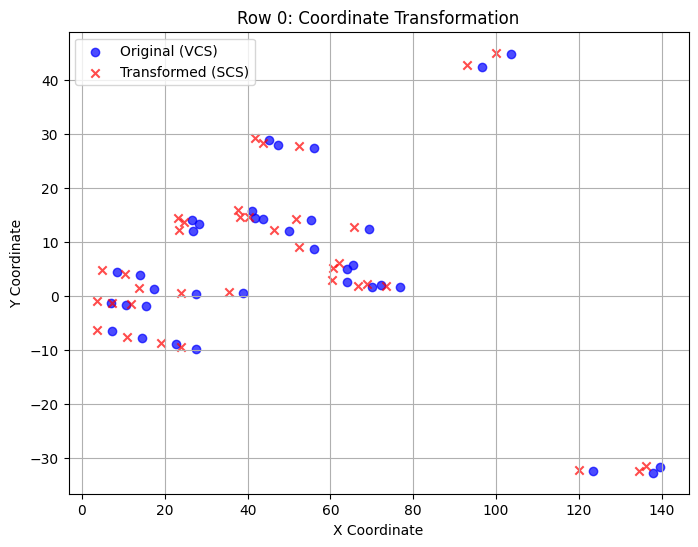

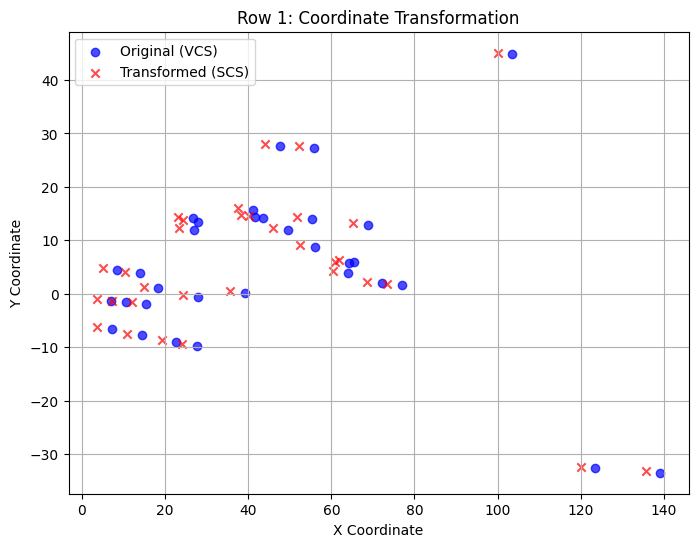

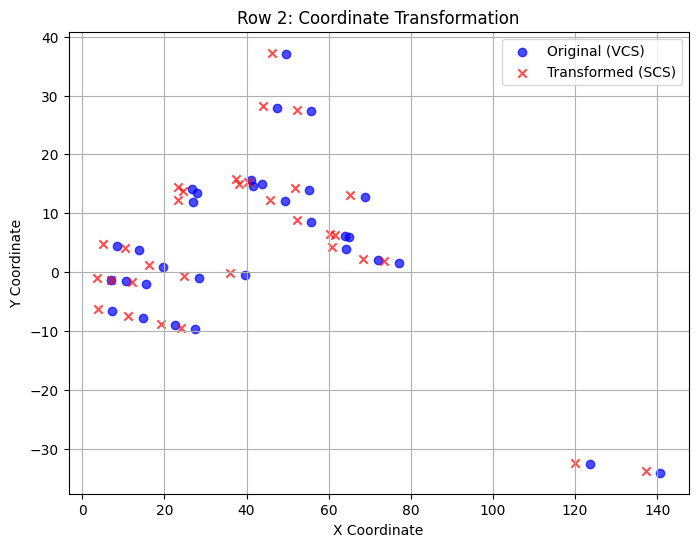

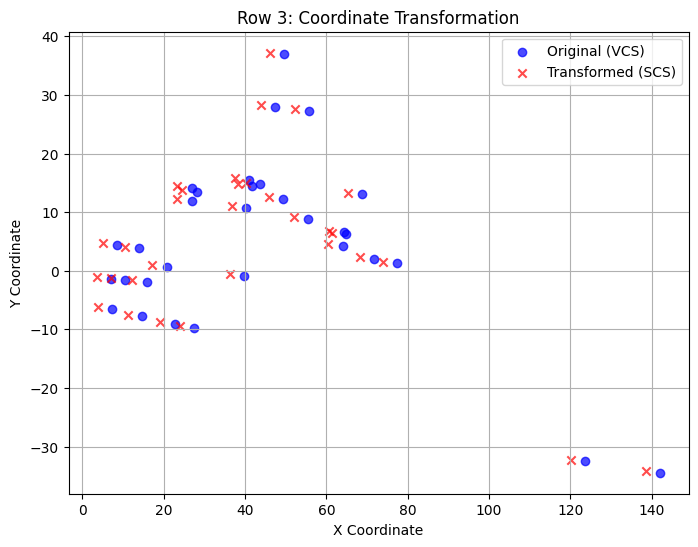

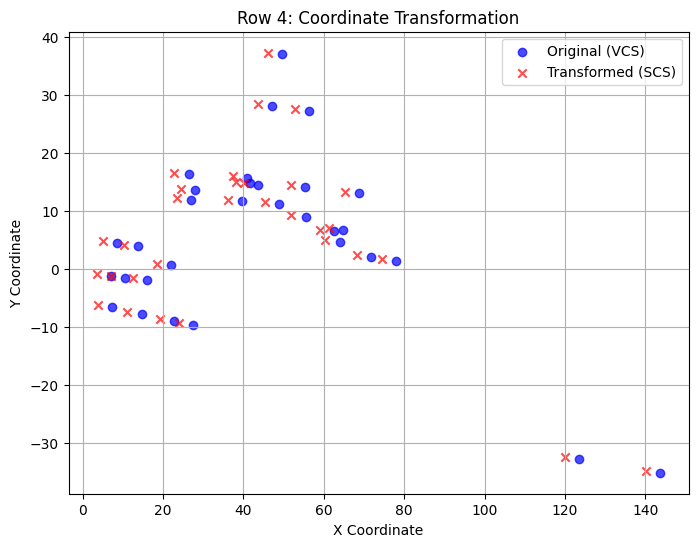

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_transformation_with_conversion(file_path, rows_to_plot=5):
    """
    Plots the old (VCS) and transformed (SCS) coordinates after ensuring they are in a suitable format.
    """
    df = pd.read_pickle(file_path)

    print(f"\n--- Plotting Old vs. Transformed Coordinates ---")

    for idx, row in df.head(rows_to_plot).iterrows():
        try:
            # Extract coordinates
            original_x = row["x"]
            original_y = row["y"]
            transformed_x = row["transformed_x"]
            transformed_y = row["transformed_y"]

            # Ensure they are in list or array format
            if isinstance(original_x, np.ndarray):
                original_x = original_x.tolist()
            if isinstance(original_y, np.ndarray):
                original_y = original_y.tolist()
            if isinstance(transformed_x, np.ndarray):
                transformed_x = transformed_x.tolist()
            if isinstance(transformed_y, np.ndarray):
                transformed_y = transformed_y.tolist()

            # Validate and convert non-list formats
            if not isinstance(original_x, list) or not isinstance(original_y, list):
                print(f"Converting original coordinates for row {idx}.")
                original_x = list(original_x)
                original_y = list(original_y)
            if not isinstance(transformed_x, list) or not isinstance(transformed_y, list):
                print(f"Converting transformed coordinates for row {idx}.")
                transformed_x = list(transformed_x)
                transformed_y = list(transformed_y)

            # Plot the coordinates
            plt.figure(figsize=(8, 6))
            plt.scatter(original_x, original_y, label="Original (VCS)", marker="o", alpha=0.7, color="blue")
            plt.scatter(transformed_x, transformed_y, label="Transformed (SCS)", marker="x", alpha=0.7, color="red")
            plt.title(f"Row {idx}: Coordinate Transformation")
            plt.xlabel("X Coordinate")
            plt.ylabel("Y Coordinate")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error plotting row {idx}: {e}")

# File path to validate
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p"

# Run the updated plot function
plot_transformation_with_conversion(file_path, rows_to_plot=5)



--- Plotting Original, Transformed Coordinates, and Centroids ---


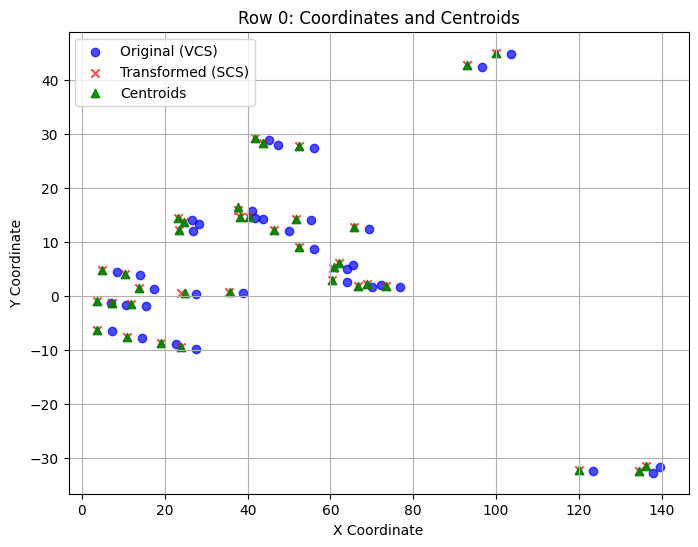

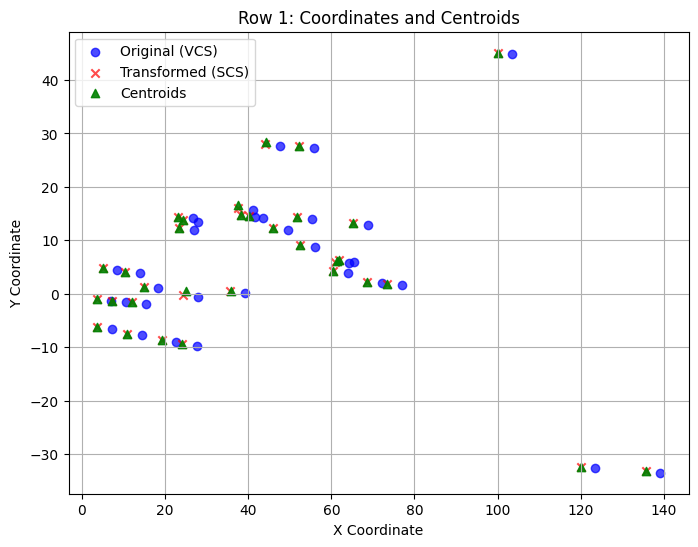

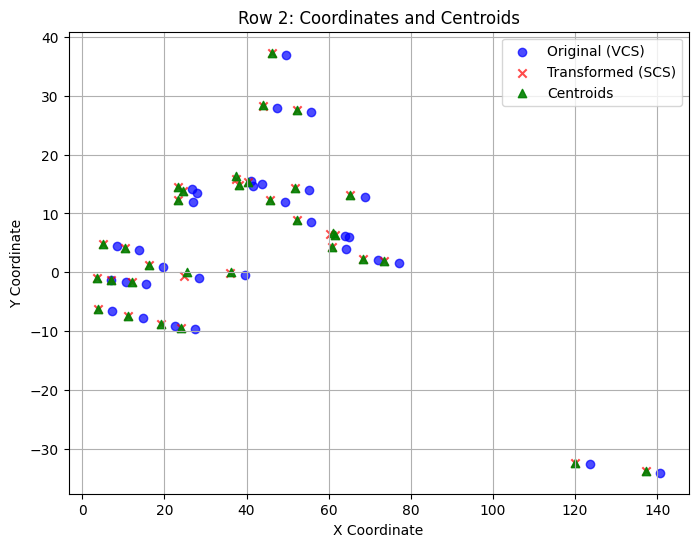

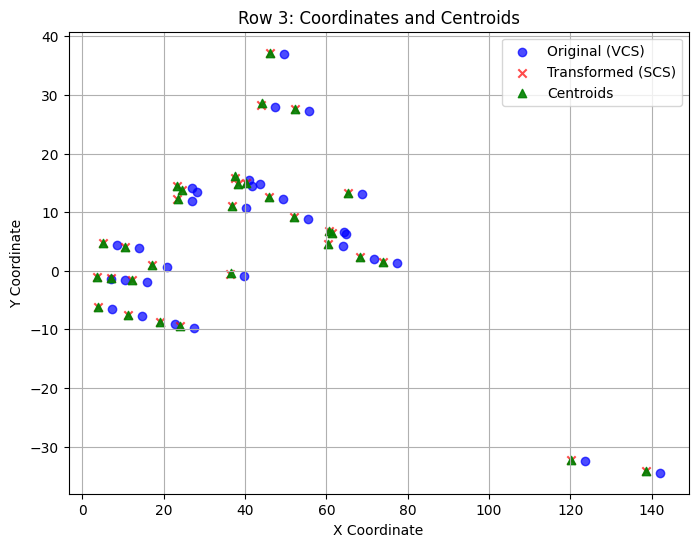

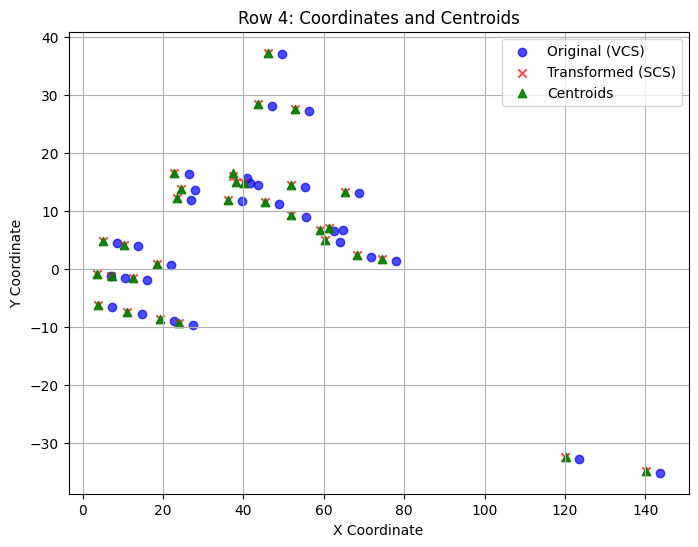

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_coordinates_with_centroids(file_path, rows_to_plot=5):
    """
    Plots original, transformed coordinates and centroids for visual analysis.
    Ensures all data is converted to suitable formats for plotting.
    """
    df = pd.read_pickle(file_path)

    print("\n--- Plotting Original, Transformed Coordinates, and Centroids ---")

    for idx, row in df.head(rows_to_plot).iterrows():
        try:
            # Extract and convert coordinates
            original_x = row["x"]
            original_y = row["y"]
            transformed_x = row["transformed_x"]
            transformed_y = row["transformed_y"]
            centroids = row["centroids"]  # Extract centroids (already computed)

            # Convert to list if necessary
            if isinstance(original_x, (np.ndarray, pd.Series)):
                original_x = original_x.tolist()
            if isinstance(original_y, (np.ndarray, pd.Series)):
                original_y = original_y.tolist()
            if isinstance(transformed_x, (np.ndarray, pd.Series)):
                transformed_x = transformed_x.tolist()
            if isinstance(transformed_y, (np.ndarray, pd.Series)):
                transformed_y = transformed_y.tolist()
            if isinstance(centroids, (np.ndarray, pd.Series)):
                centroids = centroids.tolist()

            # Check if the centroids are tuples and unpack them
            if centroids and all(isinstance(c, tuple) for c in centroids):
                centroid_x, centroid_y = zip(*centroids)
            else:
                centroid_x, centroid_y = [], []

            # Validate formats
            if not all(isinstance(v, list) for v in [original_x, original_y, transformed_x, transformed_y]):
                raise ValueError(f"Row {idx} contains non-list-based data for coordinates.")

            # Plot the data
            plt.figure(figsize=(8, 6))
            plt.scatter(original_x, original_y, label="Original (VCS)", marker="o", alpha=0.7, color="blue")
            plt.scatter(transformed_x, transformed_y, label="Transformed (SCS)", marker="x", alpha=0.7, color="red")
            plt.scatter(centroid_x, centroid_y, label="Centroids", marker="^", alpha=0.9, color="green")
            plt.title(f"Row {idx}: Coordinates and Centroids")
            plt.xlabel("X Coordinate")
            plt.ylabel("Y Coordinate")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error plotting row {idx}: {e}")

# File path to validate
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_zeroed_combined_frr40_detections_0.p"

# Run the plot function
plot_coordinates_with_centroids(file_path, rows_to_plot=5)



--- Validating `overdrivable + underdrivable` Condition ---

Row 0 - Invalid Objects:
  Object 23:
    Original Overdrivable: 4, Underdrivable: 66
    Replaced Overdrivable: 4, Underdrivable: 66
  Object 24:
    Original Overdrivable: 18, Underdrivable: 62
    Replaced Overdrivable: 18, Underdrivable: 62
  Object 25:
    Original Overdrivable: 0, Underdrivable: 97
    Replaced Overdrivable: 0, Underdrivable: 97
  Object 26:
    Original Overdrivable: 13, Underdrivable: 47
    Replaced Overdrivable: 13, Underdrivable: 47
  Object 27:
    Original Overdrivable: 0, Underdrivable: 95
    Replaced Overdrivable: 0, Underdrivable: 95


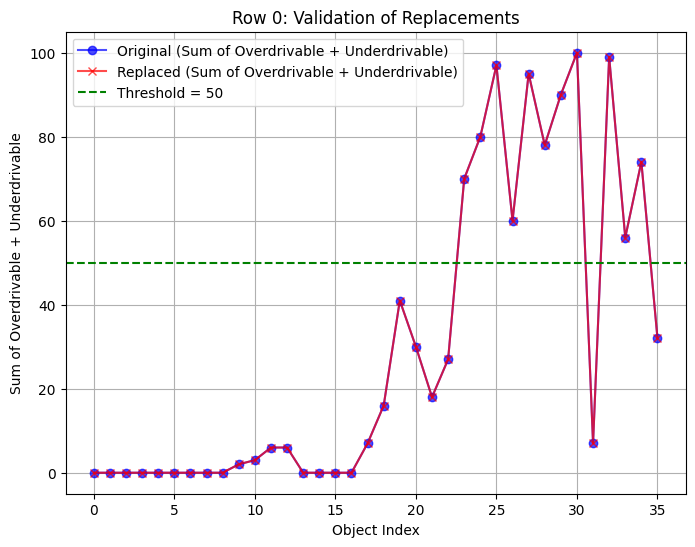


Row 1 - Invalid Objects:
  Object 22:
    Original Overdrivable: 17, Underdrivable: 61
    Replaced Overdrivable: 17, Underdrivable: 61
  Object 23:
    Original Overdrivable: 18, Underdrivable: 62
    Replaced Overdrivable: 18, Underdrivable: 62
  Object 24:
    Original Overdrivable: 0, Underdrivable: 86
    Replaced Overdrivable: 0, Underdrivable: 86
  Object 25:
    Original Overdrivable: 0, Underdrivable: 98
    Replaced Overdrivable: 0, Underdrivable: 98
  Object 26:
    Original Overdrivable: 0, Underdrivable: 89
    Replaced Overdrivable: 0, Underdrivable: 89


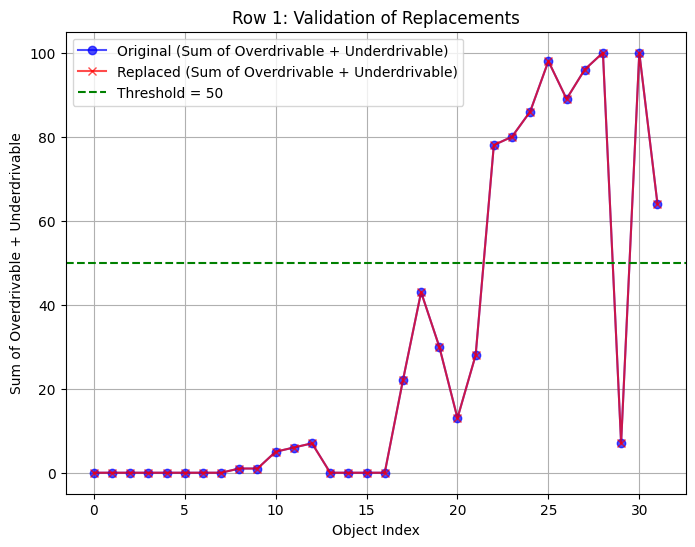


Row 2 - Invalid Objects:
  Object 23:
    Original Overdrivable: 14, Underdrivable: 48
    Replaced Overdrivable: 14, Underdrivable: 48
  Object 24:
    Original Overdrivable: 0, Underdrivable: 66
    Replaced Overdrivable: 0, Underdrivable: 66
  Object 25:
    Original Overdrivable: 15, Underdrivable: 53
    Replaced Overdrivable: 15, Underdrivable: 53
  Object 26:
    Original Overdrivable: 12, Underdrivable: 84
    Replaced Overdrivable: 12, Underdrivable: 84
  Object 27:
    Original Overdrivable: 0, Underdrivable: 99
    Replaced Overdrivable: 0, Underdrivable: 99


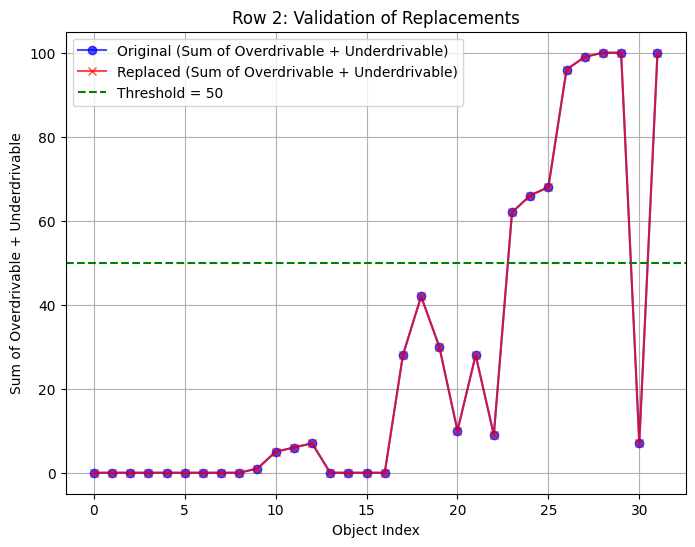


Row 3 - Invalid Objects:
  Object 23:
    Original Overdrivable: 0, Underdrivable: 57
    Replaced Overdrivable: 0, Underdrivable: 57
  Object 24:
    Original Overdrivable: 13, Underdrivable: 45
    Replaced Overdrivable: 13, Underdrivable: 45
  Object 25:
    Original Overdrivable: 0, Underdrivable: 99
    Replaced Overdrivable: 0, Underdrivable: 99
  Object 26:
    Original Overdrivable: 17, Underdrivable: 83
    Replaced Overdrivable: 17, Underdrivable: 83
  Object 27:
    Original Overdrivable: 0, Underdrivable: 100
    Replaced Overdrivable: 0, Underdrivable: 100


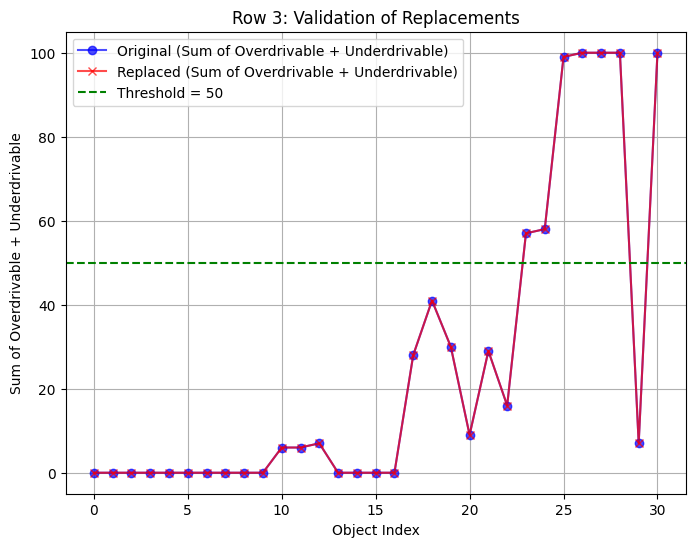


Row 4 - Invalid Objects:
  Object 22:
    Original Overdrivable: 15, Underdrivable: 55
    Replaced Overdrivable: 15, Underdrivable: 55
  Object 24:
    Original Overdrivable: 16, Underdrivable: 58
    Replaced Overdrivable: 16, Underdrivable: 58
  Object 25:
    Original Overdrivable: 20, Underdrivable: 80
    Replaced Overdrivable: 20, Underdrivable: 80
  Object 26:
    Original Overdrivable: 0, Underdrivable: 100
    Replaced Overdrivable: 0, Underdrivable: 100
  Object 27:
    Original Overdrivable: 0, Underdrivable: 100
    Replaced Overdrivable: 0, Underdrivable: 100


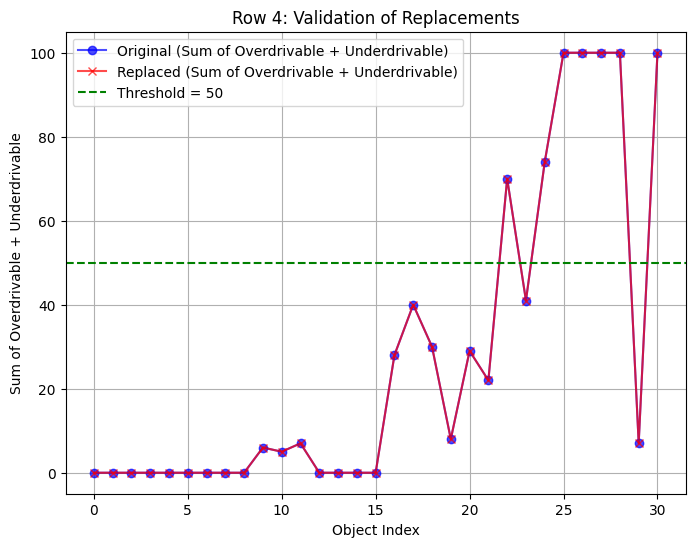

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def validate_overdrivable_condition(file_path_original, file_path_replaced, rows_to_check=5):
    """
    Validates if the `overdrivable + underdrivable > 50` condition was applied correctly.
    Compares original and replaced values for a few objects and visualizes them.
    """
    # Load original and replaced data
    original_data = pd.read_pickle(file_path_original)
    replaced_data = pd.read_pickle(file_path_replaced)

    print("\n--- Validating `overdrivable + underdrivable` Condition ---")

    # Iterate through rows to check a few invalid objects
    for idx, (orig_row, repl_row) in enumerate(zip(original_data.iterrows(), replaced_data.iterrows())):
        if idx >= rows_to_check:
            break

        orig_row = orig_row[1]
        repl_row = repl_row[1]

        try:
            # Extract overdrivable and underdrivable values
            orig_overdrivable = orig_row["overdrivable"]
            orig_underdrivable = orig_row["underdrivable"]
            repl_overdrivable = repl_row["overdrivable"]
            repl_underdrivable = repl_row["underdrivable"]

            # Convert to lists for uniform comparison
            if not isinstance(orig_overdrivable, list):
                orig_overdrivable = list(orig_overdrivable)
            if not isinstance(orig_underdrivable, list):
                orig_underdrivable = list(orig_underdrivable)
            if not isinstance(repl_overdrivable, list):
                repl_overdrivable = list(repl_overdrivable)
            if not isinstance(repl_underdrivable, list):
                repl_underdrivable = list(repl_underdrivable)

            # Identify invalid indices
            invalid_indices = [
                i for i in range(len(orig_overdrivable))
                if orig_overdrivable[i] + orig_underdrivable[i] > 50
            ]

            # Check replacements
            print(f"\nRow {idx} - Invalid Objects:")
            for i in invalid_indices[:5]:  # Show only the first 5 invalid objects
                print(f"  Object {i}:")
                print(f"    Original Overdrivable: {orig_overdrivable[i]}, Underdrivable: {orig_underdrivable[i]}")
                print(f"    Replaced Overdrivable: {repl_overdrivable[i]}, Underdrivable: {repl_underdrivable[i]}")

            # Plot original vs replaced values for visualization
            plt.figure(figsize=(8, 6))
            plt.plot(
                range(len(orig_overdrivable)),
                [orig_overdrivable[i] + orig_underdrivable[i] for i in range(len(orig_overdrivable))],
                label="Original (Sum of Overdrivable + Underdrivable)",
                marker="o",
                alpha=0.7,
                color="blue",
            )
            plt.plot(
                range(len(repl_overdrivable)),
                [repl_overdrivable[i] + repl_underdrivable[i] for i in range(len(repl_overdrivable))],
                label="Replaced (Sum of Overdrivable + Underdrivable)",
                marker="x",
                alpha=0.7,
                color="red",
            )
            plt.title(f"Row {idx}: Validation of Replacements")
            plt.xlabel("Object Index")
            plt.ylabel("Sum of Overdrivable + Underdrivable")
            plt.axhline(50, color="green", linestyle="--", label="Threshold = 50")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error validating row {idx}: {e}")

# File paths for validation
file_path_original = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\combined_frr40_detections_0.p"
file_path_replaced = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\zeroed_combined_frr40_detections_0.p"

# Run validation
validate_overdrivable_condition(file_path_original, file_path_replaced, rows_to_check=5)



--- Validating `overdrivable + underdrivable` Condition and Related Columns ---

Row 0 - Invalid Objects and Respective Column Values:
  Object 23:
    Original Overdrivable: 4, Underdrivable: 66
    Replaced Overdrivable: 4, Underdrivable: 66
    Column: rcs, Original Value: -18, Replaced Value: -18
    Column: distance, Original Value: 11.979999542236328, Replaced Value: 11.979999542236328
    Column: angleAzimuth, Original Value: 0.3698703348636627, Replaced Value: 0.3698703348636627
    Column: angleElevation, Original Value: -0.04110252112150192, Replaced Value: -0.04110252112150192
    Column: radialVelocity, Original Value: -0.14499999582767487, Replaced Value: -0.14499999582767487
    Column: orientation, Original Value: 0.49079281091690063, Replaced Value: 0.49079281091690063
    Column: x, Original Value: 45.21999740600586, Replaced Value: 45.21999740600586
    Column: y, Original Value: 28.94999885559082, Replaced Value: 28.94999885559082
    Column: width_edge_mean, Origin

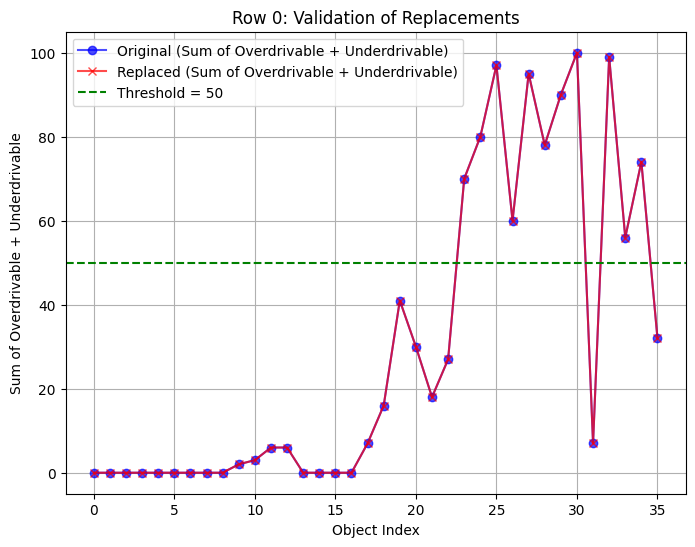


Row 1 - Invalid Objects and Respective Column Values:
  Object 22:
    Original Overdrivable: 17, Underdrivable: 61
    Replaced Overdrivable: 17, Underdrivable: 61
    Column: rcs, Original Value: -24, Replaced Value: -24
    Column: distance, Original Value: 10.469999313354492, Replaced Value: 10.469999313354492
    Column: angleAzimuth, Original Value: 0.4228062033653259, Replaced Value: 0.4228062033653259
    Column: angleElevation, Original Value: -0.06948158890008926, Replaced Value: -0.06948158890008926
    Column: radialVelocity, Original Value: -0.02499999850988388, Replaced Value: -0.02499999850988388
    Column: orientation, Original Value: 1.2416990995407104, Replaced Value: 1.2416990995407104
    Column: x, Original Value: 55.279998779296875, Replaced Value: 55.279998779296875
    Column: y, Original Value: 14.0, Replaced Value: 14.0
    Column: width_edge_mean, Original Value: 0.3799999952316284, Replaced Value: 0.3799999952316284
    Column: length_edge_mean, Original V

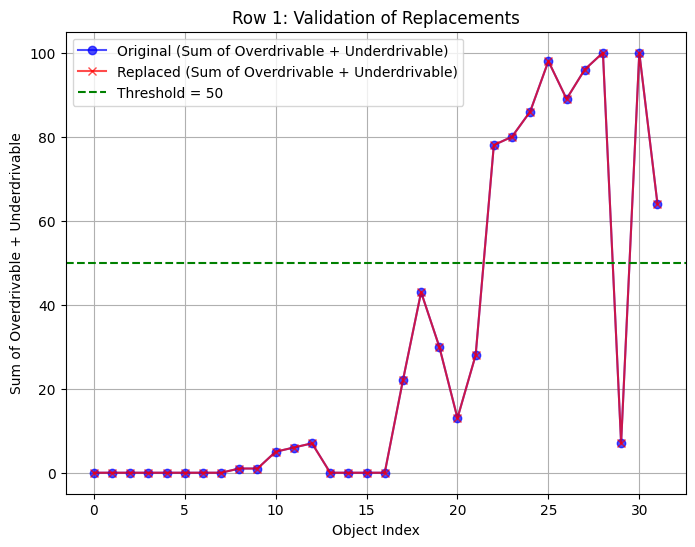


Row 2 - Invalid Objects and Respective Column Values:
  Object 23:
    Original Overdrivable: 14, Underdrivable: 48
    Replaced Overdrivable: 14, Underdrivable: 48
    Column: rcs, Original Value: -22, Replaced Value: -22
    Column: distance, Original Value: 11.239999771118164, Replaced Value: 11.239999771118164
    Column: angleAzimuth, Original Value: -0.5719795823097229, Replaced Value: -0.5719795823097229
    Column: angleElevation, Original Value: -0.010053100995719433, Replaced Value: -0.010053100995719433
    Column: radialVelocity, Original Value: 0.07499999552965164, Replaced Value: 0.07499999552965164
    Column: orientation, Original Value: 1.2418909072875977, Replaced Value: 1.2418909072875977
    Column: x, Original Value: 55.279998779296875, Replaced Value: 55.279998779296875
    Column: y, Original Value: 14.00999927520752, Replaced Value: 14.00999927520752
    Column: width_edge_mean, Original Value: 0.3799999952316284, Replaced Value: 0.3799999952316284
    Column: 

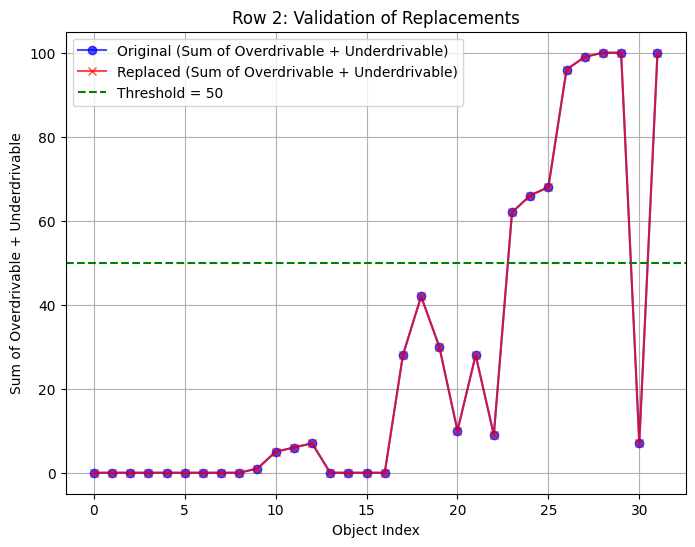


Row 3 - Invalid Objects and Respective Column Values:
  Object 23:
    Original Overdrivable: 0, Underdrivable: 57
    Replaced Overdrivable: 0, Underdrivable: 57
    Column: rcs, Original Value: -2, Replaced Value: -2
    Column: distance, Original Value: 11.170000076293945, Replaced Value: 11.170000076293945
    Column: angleAzimuth, Original Value: 0.4015480875968933, Replaced Value: 0.4015480875968933
    Column: angleElevation, Original Value: -0.044924795627593994, Replaced Value: -0.044924795627593994
    Column: radialVelocity, Original Value: 0.06499999761581421, Replaced Value: 0.06499999761581421
    Column: orientation, Original Value: 0.0, Replaced Value: 0.0
    Column: x, Original Value: 55.55999755859375, Replaced Value: 55.55999755859375
    Column: y, Original Value: 8.84999942779541, Replaced Value: 8.84999942779541
    Column: width_edge_mean, Original Value: 2.859999895095825, Replaced Value: 2.859999895095825
    Column: length_edge_mean, Original Value: 4.730000

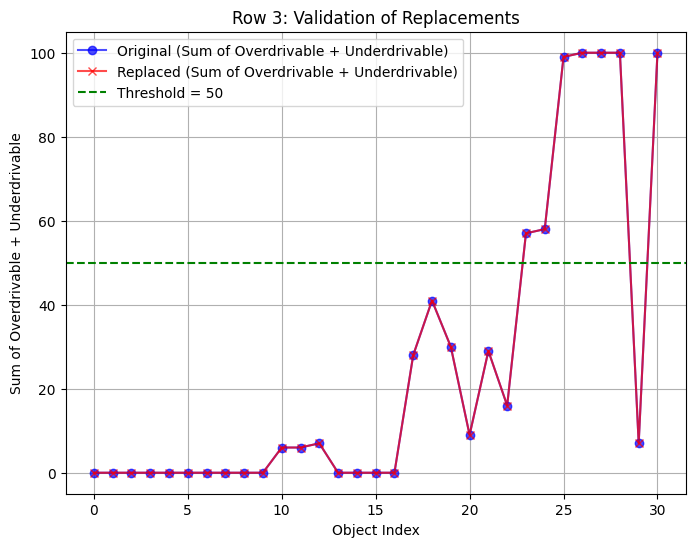


Row 4 - Invalid Objects and Respective Column Values:
  Object 22:
    Original Overdrivable: 15, Underdrivable: 55
    Replaced Overdrivable: 15, Underdrivable: 55
    Column: rcs, Original Value: -23, Replaced Value: -23
    Column: distance, Original Value: 10.449999809265137, Replaced Value: 10.449999809265137
    Column: angleAzimuth, Original Value: 0.426104873418808, Replaced Value: 0.426104873418808
    Column: angleElevation, Original Value: -0.07162834703922272, Replaced Value: -0.07162834703922272
    Column: radialVelocity, Original Value: 0.009999999776482582, Replaced Value: 0.009999999776482582
    Column: orientation, Original Value: 1.2407402992248535, Replaced Value: 1.2407402992248535
    Column: x, Original Value: 55.2599983215332, Replaced Value: 55.2599983215332
    Column: y, Original Value: 14.069999694824219, Replaced Value: 14.069999694824219
    Column: width_edge_mean, Original Value: 0.3499999940395355, Replaced Value: 0.3499999940395355
    Column: length

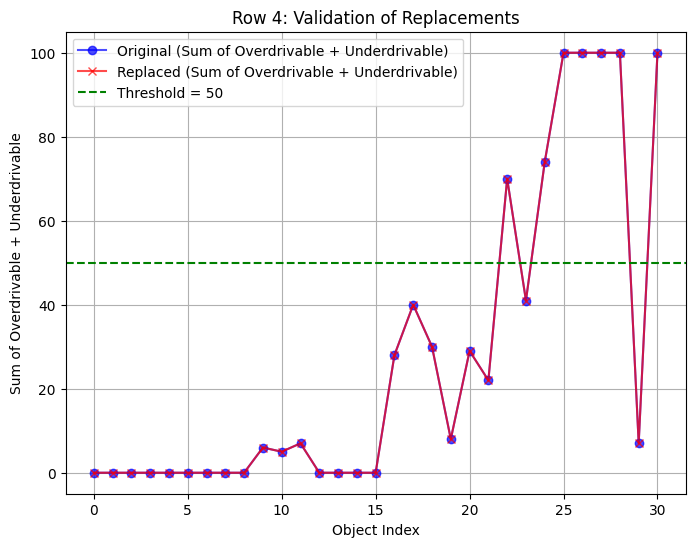

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def validate_overdrivable_condition_with_columns(file_path_original, file_path_replaced, columns_to_check, rows_to_check=5):
    """
    Validates if the `overdrivable + underdrivable > 50` condition was applied correctly.
    Compares original and replaced values across specified columns for a few objects and visualizes them.
    """
    # Load original and replaced data
    original_data = pd.read_pickle(file_path_original)
    replaced_data = pd.read_pickle(file_path_replaced)

    print("\n--- Validating `overdrivable + underdrivable` Condition and Related Columns ---")

    for idx, (orig_row, repl_row) in enumerate(zip(original_data.iterrows(), replaced_data.iterrows())):
        if idx >= rows_to_check:
            break

        orig_row = orig_row[1]
        repl_row = repl_row[1]

        try:
            # Extract overdrivable and underdrivable values
            orig_overdrivable = orig_row["overdrivable"]
            orig_underdrivable = orig_row["underdrivable"]
            repl_overdrivable = repl_row["overdrivable"]
            repl_underdrivable = repl_row["underdrivable"]

            # Convert to lists for uniform comparison
            if not isinstance(orig_overdrivable, list):
                orig_overdrivable = list(orig_overdrivable)
            if not isinstance(orig_underdrivable, list):
                orig_underdrivable = list(orig_underdrivable)
            if not isinstance(repl_overdrivable, list):
                repl_overdrivable = list(repl_overdrivable)
            if not isinstance(repl_underdrivable, list):
                repl_underdrivable = list(repl_underdrivable)

            # Identify invalid indices
            invalid_indices = [
                i for i in range(len(orig_overdrivable))
                if orig_overdrivable[i] + orig_underdrivable[i] > 50
            ]

            print(f"\nRow {idx} - Invalid Objects and Respective Column Values:")
            for i in invalid_indices[:5]:  # Show only the first 5 invalid objects
                print(f"  Object {i}:")
                print(f"    Original Overdrivable: {orig_overdrivable[i]}, Underdrivable: {orig_underdrivable[i]}")
                print(f"    Replaced Overdrivable: {repl_overdrivable[i]}, Underdrivable: {repl_underdrivable[i]}")
                for col in columns_to_check:
                    orig_value = orig_row[col][i] if i < len(orig_row[col]) else None
                    repl_value = repl_row[col][i] if i < len(repl_row[col]) else None
                    print(f"    Column: {col}, Original Value: {orig_value}, Replaced Value: {repl_value}")

            # Visualization
            plt.figure(figsize=(8, 6))
            plt.plot(
                range(len(orig_overdrivable)),
                [orig_overdrivable[i] + orig_underdrivable[i] for i in range(len(orig_overdrivable))],
                label="Original (Sum of Overdrivable + Underdrivable)",
                marker="o",
                alpha=0.7,
                color="blue",
            )
            plt.plot(
                range(len(repl_overdrivable)),
                [repl_overdrivable[i] + repl_underdrivable[i] for i in range(len(repl_overdrivable))],
                label="Replaced (Sum of Overdrivable + Underdrivable)",
                marker="x",
                alpha=0.7,
                color="red",
            )
            plt.title(f"Row {idx}: Validation of Replacements")
            plt.xlabel("Object Index")
            plt.ylabel("Sum of Overdrivable + Underdrivable")
            plt.axhline(50, color="green", linestyle="--", label="Threshold = 50")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error validating row {idx}: {e}")

# File paths for validation
file_path_original = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\combined_frr40_detections_0.p"
file_path_replaced = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_zeroed_combined_frr40_detections_0.p"

# Columns to check for respective values
columns_to_check = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean"
]

# Run validation
validate_overdrivable_condition_with_columns(file_path_original, file_path_replaced, columns_to_check, rows_to_check=5)



--- Validating Conditions and Related Columns ---

Row 0 - Condition Validation:
  Object 23 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 4, Underdrivable: 66
    Replaced Overdrivable: 4, Underdrivable: 66
    Column: rcs, Original Value: -18, Replaced Value: -18
    Column: distance, Original Value: 11.979999542236328, Replaced Value: 11.979999542236328
    Column: angleAzimuth, Original Value: 0.3698703348636627, Replaced Value: 0.3698703348636627
    Column: angleElevation, Original Value: -0.04110252112150192, Replaced Value: -0.04110252112150192
    Column: radialVelocity, Original Value: -0.14499999582767487, Replaced Value: -0.14499999582767487
    Column: orientation, Original Value: 0.49079281091690063, Replaced Value: 0.49079281091690063
    Column: x, Original Value: 45.21999740600586, Replaced Value: 45.21999740600586
    Column: y, Original Value: 28.94999885559082, Replaced Value: 28.94999885559082
    Column: width_edge_mean, Original Value: 0.7

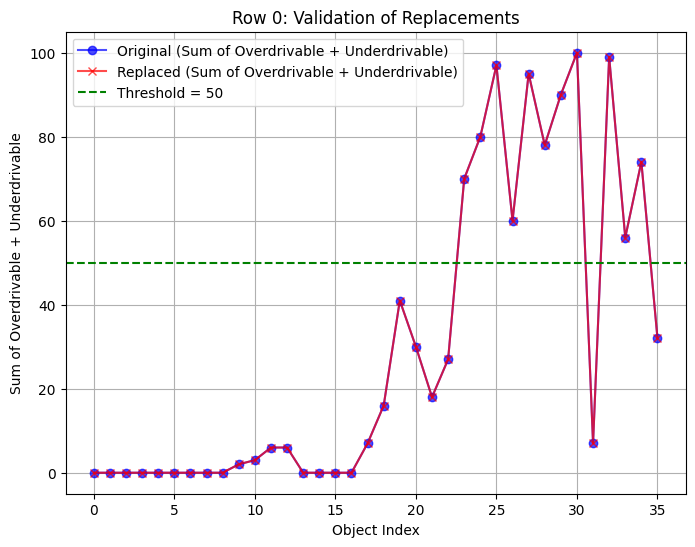


Row 1 - Condition Validation:
  Object 22 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 17, Underdrivable: 61
    Replaced Overdrivable: 17, Underdrivable: 61
    Column: rcs, Original Value: -24, Replaced Value: -24
    Column: distance, Original Value: 10.469999313354492, Replaced Value: 10.469999313354492
    Column: angleAzimuth, Original Value: 0.4228062033653259, Replaced Value: 0.4228062033653259
    Column: angleElevation, Original Value: -0.06948158890008926, Replaced Value: -0.06948158890008926
    Column: radialVelocity, Original Value: -0.02499999850988388, Replaced Value: -0.02499999850988388
    Column: orientation, Original Value: 1.2416990995407104, Replaced Value: 1.2416990995407104
    Column: x, Original Value: 55.279998779296875, Replaced Value: 55.279998779296875
    Column: y, Original Value: 14.0, Replaced Value: 14.0
    Column: width_edge_mean, Original Value: 0.3799999952316284, Replaced Value: 0.3799999952316284
    Column: length_edge

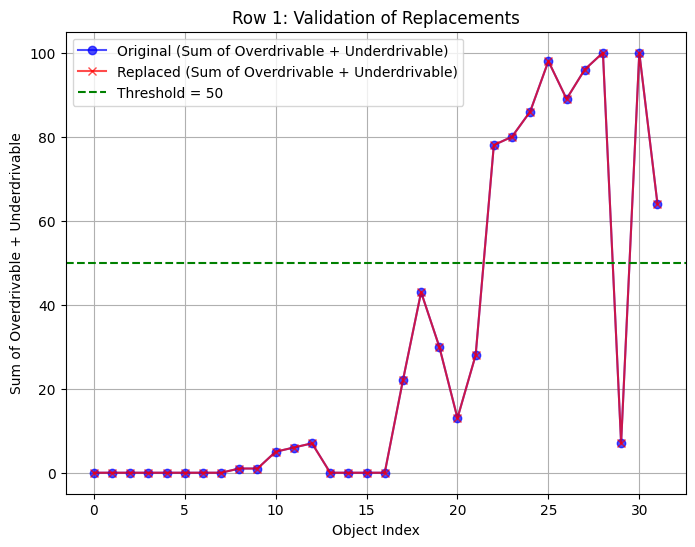


Row 2 - Condition Validation:
  Object 23 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 14, Underdrivable: 48
    Replaced Overdrivable: 14, Underdrivable: 48
    Column: rcs, Original Value: -22, Replaced Value: -22
    Column: distance, Original Value: 11.239999771118164, Replaced Value: 11.239999771118164
    Column: angleAzimuth, Original Value: -0.5719795823097229, Replaced Value: -0.5719795823097229
    Column: angleElevation, Original Value: -0.010053100995719433, Replaced Value: -0.010053100995719433
    Column: radialVelocity, Original Value: 0.07499999552965164, Replaced Value: 0.07499999552965164
    Column: orientation, Original Value: 1.2418909072875977, Replaced Value: 1.2418909072875977
    Column: x, Original Value: 55.279998779296875, Replaced Value: 55.279998779296875
    Column: y, Original Value: 14.00999927520752, Replaced Value: 14.00999927520752
    Column: width_edge_mean, Original Value: 0.3799999952316284, Replaced Value: 0.379999995231

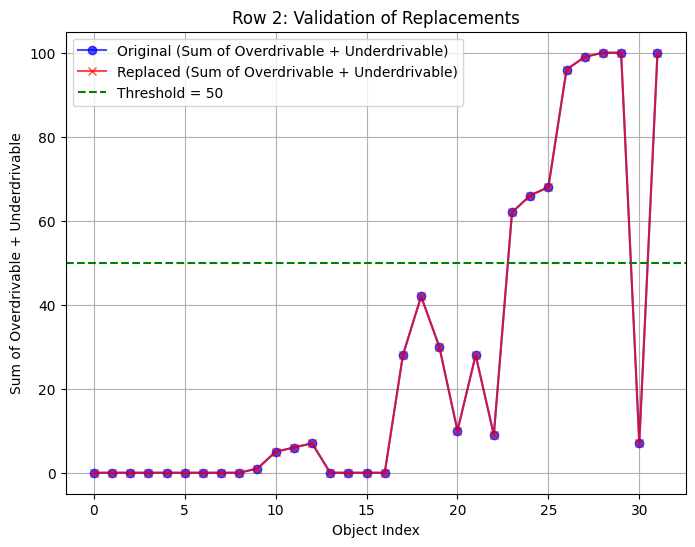


Row 3 - Condition Validation:
  Object 23 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 0, Underdrivable: 57
    Replaced Overdrivable: 0, Underdrivable: 57
    Column: rcs, Original Value: -2, Replaced Value: -2
    Column: distance, Original Value: 11.170000076293945, Replaced Value: 11.170000076293945
    Column: angleAzimuth, Original Value: 0.4015480875968933, Replaced Value: 0.4015480875968933
    Column: angleElevation, Original Value: -0.044924795627593994, Replaced Value: -0.044924795627593994
    Column: radialVelocity, Original Value: 0.06499999761581421, Replaced Value: 0.06499999761581421
    Column: orientation, Original Value: 0.0, Replaced Value: 0.0
    Column: x, Original Value: 55.55999755859375, Replaced Value: 55.55999755859375
    Column: y, Original Value: 8.84999942779541, Replaced Value: 8.84999942779541
    Column: width_edge_mean, Original Value: 2.859999895095825, Replaced Value: 2.859999895095825
    Column: length_edge_mean, Origina

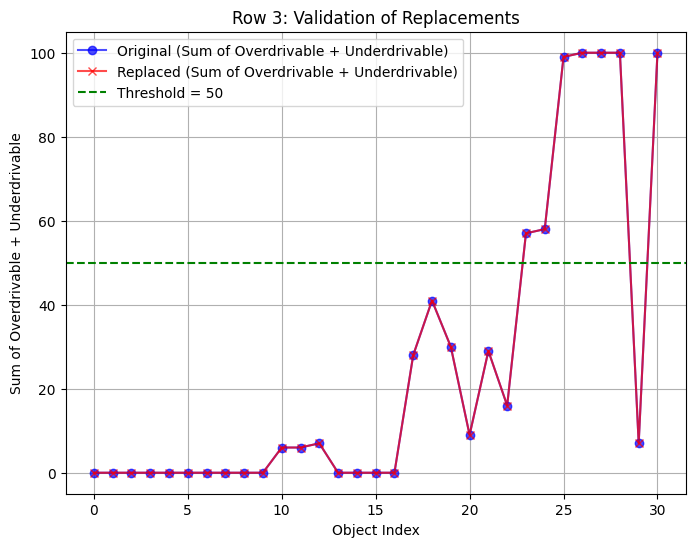


Row 4 - Condition Validation:
  Object 22 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 15, Underdrivable: 55
    Replaced Overdrivable: 15, Underdrivable: 55
    Column: rcs, Original Value: -23, Replaced Value: -23
    Column: distance, Original Value: 10.449999809265137, Replaced Value: 10.449999809265137
    Column: angleAzimuth, Original Value: 0.426104873418808, Replaced Value: 0.426104873418808
    Column: angleElevation, Original Value: -0.07162834703922272, Replaced Value: -0.07162834703922272
    Column: radialVelocity, Original Value: 0.009999999776482582, Replaced Value: 0.009999999776482582
    Column: orientation, Original Value: 1.2407402992248535, Replaced Value: 1.2407402992248535
    Column: x, Original Value: 55.2599983215332, Replaced Value: 55.2599983215332
    Column: y, Original Value: 14.069999694824219, Replaced Value: 14.069999694824219
    Column: width_edge_mean, Original Value: 0.3499999940395355, Replaced Value: 0.3499999940395355
 

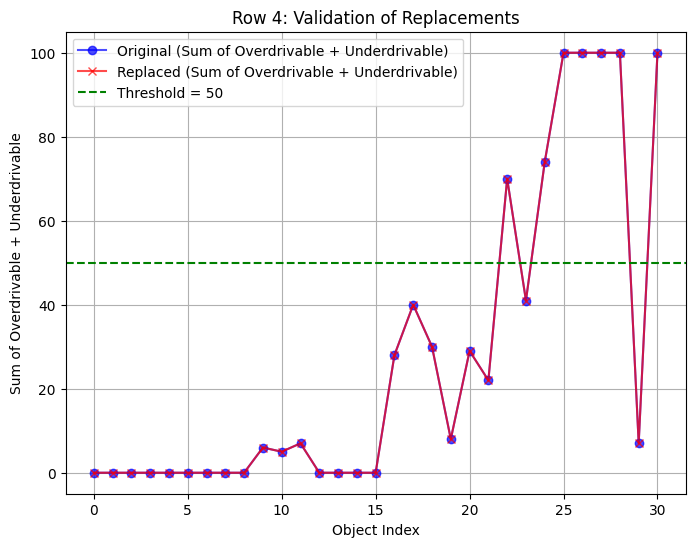

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def validate_conditions_with_columns(file_path_original, file_path_replaced, columns_to_check, rows_to_check=5):
    """
    Validates the following conditions:
    1. `overdrivable + underdrivable > 50` replaced correctly.
    2. `status_measurement == (0, 'measured')` condition applied.
    3. `status_movement == (0, 'moved')` condition applied.

    Compares original and replaced values across specified columns and visualizes results.
    """
    # Load original and replaced data
    original_data = pd.read_pickle(file_path_original)
    replaced_data = pd.read_pickle(file_path_replaced)

    print("\n--- Validating Conditions and Related Columns ---")

    for idx, (orig_row, repl_row) in enumerate(zip(original_data.iterrows(), replaced_data.iterrows())):
        if idx >= rows_to_check:
            break

        orig_row = orig_row[1]
        repl_row = repl_row[1]

        try:
            # Extract conditions
            orig_overdrivable = orig_row["overdrivable"]
            orig_underdrivable = orig_row["underdrivable"]
            repl_overdrivable = repl_row["overdrivable"]
            repl_underdrivable = repl_row["underdrivable"]

            orig_status_measurement = orig_row["status_measurement"]
            repl_status_measurement = repl_row["status_measurement"]

            orig_status_movement = orig_row["status_movement"]
            repl_status_movement = repl_row["status_movement"]

            # Convert to lists for uniform comparison
            if not isinstance(orig_overdrivable, list):
                orig_overdrivable = list(orig_overdrivable)
            if not isinstance(orig_underdrivable, list):
                orig_underdrivable = list(orig_underdrivable)
            if not isinstance(repl_overdrivable, list):
                repl_overdrivable = list(repl_overdrivable)
            if not isinstance(repl_underdrivable, list):
                repl_underdrivable = list(repl_underdrivable)

            invalid_indices = [
                i for i in range(len(orig_overdrivable))
                if orig_overdrivable[i] + orig_underdrivable[i] > 50
            ]

            print(f"\nRow {idx} - Condition Validation:")
            for i in invalid_indices[:5]:  # Show only the first 5 invalid objects
                print(f"  Object {i} (Invalid `overdrivable + underdrivable`):")
                print(f"    Original Overdrivable: {orig_overdrivable[i]}, Underdrivable: {orig_underdrivable[i]}")
                print(f"    Replaced Overdrivable: {repl_overdrivable[i]}, Underdrivable: {repl_underdrivable[i]}")
                for col in columns_to_check:
                    orig_value = orig_row[col][i] if i < len(orig_row[col]) else None
                    repl_value = repl_row[col][i] if i < len(repl_row[col]) else None
                    print(f"    Column: {col}, Original Value: {orig_value}, Replaced Value: {repl_value}")

            measured_indices = [
                i for i in range(len(orig_status_measurement))
                if orig_status_measurement[i] != (0, "measured")
            ]

            for i in measured_indices[:5]:  # Show only the first 5 invalid objects
                print(f"  Object {i} (Invalid `status_measurement`):")
                print(f"    Original Status: {orig_status_measurement[i]}")
                print(f"    Replaced Status: {repl_status_measurement[i]}")
                for col in columns_to_check:
                    orig_value = orig_row[col][i] if i < len(orig_row[col]) else None
                    repl_value = repl_row[col][i] if i < len(repl_row[col]) else None
                    print(f"    Column: {col}, Original Value: {orig_value}, Replaced Value: {repl_value}")

            moved_indices = [
                i for i in range(len(orig_status_movement))
                if orig_status_movement[i] != (0, "moved")
            ]

            for i in moved_indices[:5]:  # Show only the first 5 invalid objects
                print(f"  Object {i} (Invalid `status_movement`):")
                print(f"    Original Status: {orig_status_movement[i]}")
                print(f"    Replaced Status: {repl_status_movement[i]}")
                for col in columns_to_check:
                    orig_value = orig_row[col][i] if i < len(orig_row[col]) else None
                    repl_value = repl_row[col][i] if i < len(repl_row[col]) else None
                    print(f"    Column: {col}, Original Value: {orig_value}, Replaced Value: {repl_value}")

            # Visualization
            plt.figure(figsize=(8, 6))
            plt.plot(
                range(len(orig_overdrivable)),
                [orig_overdrivable[i] + orig_underdrivable[i] for i in range(len(orig_overdrivable))],
                label="Original (Sum of Overdrivable + Underdrivable)",
                marker="o",
                alpha=0.7,
                color="blue",
            )
            plt.plot(
                range(len(repl_overdrivable)),
                [repl_overdrivable[i] + repl_underdrivable[i] for i in range(len(repl_overdrivable))],
                label="Replaced (Sum of Overdrivable + Underdrivable)",
                marker="x",
                alpha=0.7,
                color="red",
            )
            plt.title(f"Row {idx}: Validation of Replacements")
            plt.xlabel("Object Index")
            plt.ylabel("Sum of Overdrivable + Underdrivable")
            plt.axhline(50, color="green", linestyle="--", label="Threshold = 50")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error validating row {idx}: {e}")

# File paths for validation
file_path_original = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\combined_frr40_detections_0.p"
file_path_replaced = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_zeroed_combined_frr40_detections_0.p"

# Columns to check for respective values
columns_to_check = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean"
]

# Run validation
validate_conditions_with_columns(file_path_original, file_path_replaced, columns_to_check, rows_to_check=5)



--- Validating Conditions and Related Columns ---

Row 0 - Condition Validation:
  Object 23 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 4, Underdrivable: 66
    Replaced Overdrivable: 4, Underdrivable: 66
    Column: rcs, Original Value: -18, Replaced Value: -18
    Column: distance, Original Value: 11.979999542236328, Replaced Value: 11.979999542236328
    Column: angleAzimuth, Original Value: 0.3698703348636627, Replaced Value: 0.3698703348636627
    Column: angleElevation, Original Value: -0.04110252112150192, Replaced Value: -0.04110252112150192
    Column: radialVelocity, Original Value: -0.14499999582767487, Replaced Value: -0.14499999582767487
    Column: orientation, Original Value: 0.49079281091690063, Replaced Value: 0.49079281091690063
    Column: x, Original Value: 45.21999740600586, Replaced Value: 45.21999740600586
    Column: y, Original Value: 28.94999885559082, Replaced Value: 28.94999885559082
    Column: width_edge_mean, Original Value: 0.7

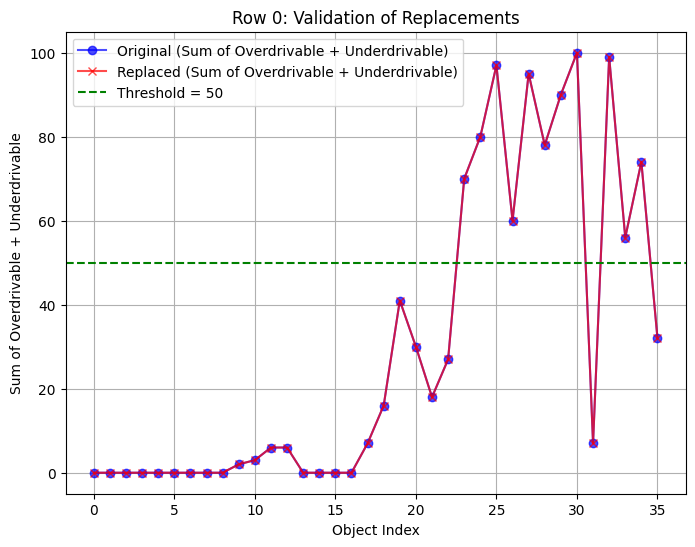


Row 1 - Condition Validation:
  Object 22 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 17, Underdrivable: 61
    Replaced Overdrivable: 17, Underdrivable: 61
    Column: rcs, Original Value: -24, Replaced Value: -24
    Column: distance, Original Value: 10.469999313354492, Replaced Value: 10.469999313354492
    Column: angleAzimuth, Original Value: 0.4228062033653259, Replaced Value: 0.4228062033653259
    Column: angleElevation, Original Value: -0.06948158890008926, Replaced Value: -0.06948158890008926
    Column: radialVelocity, Original Value: -0.02499999850988388, Replaced Value: -0.02499999850988388
    Column: orientation, Original Value: 1.2416990995407104, Replaced Value: 1.2416990995407104
    Column: x, Original Value: 55.279998779296875, Replaced Value: 55.279998779296875
    Column: y, Original Value: 14.0, Replaced Value: 14.0
    Column: width_edge_mean, Original Value: 0.3799999952316284, Replaced Value: 0.3799999952316284
    Column: length_edge

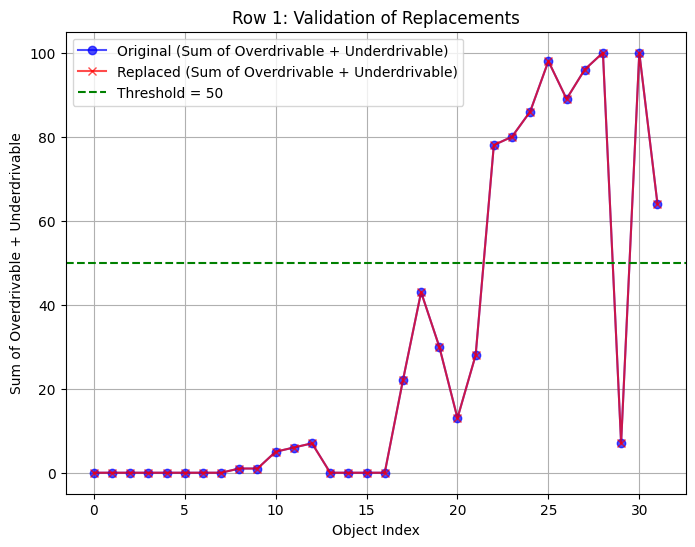


Row 2 - Condition Validation:
  Object 23 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 14, Underdrivable: 48
    Replaced Overdrivable: 14, Underdrivable: 48
    Column: rcs, Original Value: -22, Replaced Value: -22
    Column: distance, Original Value: 11.239999771118164, Replaced Value: 11.239999771118164
    Column: angleAzimuth, Original Value: -0.5719795823097229, Replaced Value: -0.5719795823097229
    Column: angleElevation, Original Value: -0.010053100995719433, Replaced Value: -0.010053100995719433
    Column: radialVelocity, Original Value: 0.07499999552965164, Replaced Value: 0.07499999552965164
    Column: orientation, Original Value: 1.2418909072875977, Replaced Value: 1.2418909072875977
    Column: x, Original Value: 55.279998779296875, Replaced Value: 55.279998779296875
    Column: y, Original Value: 14.00999927520752, Replaced Value: 14.00999927520752
    Column: width_edge_mean, Original Value: 0.3799999952316284, Replaced Value: 0.379999995231

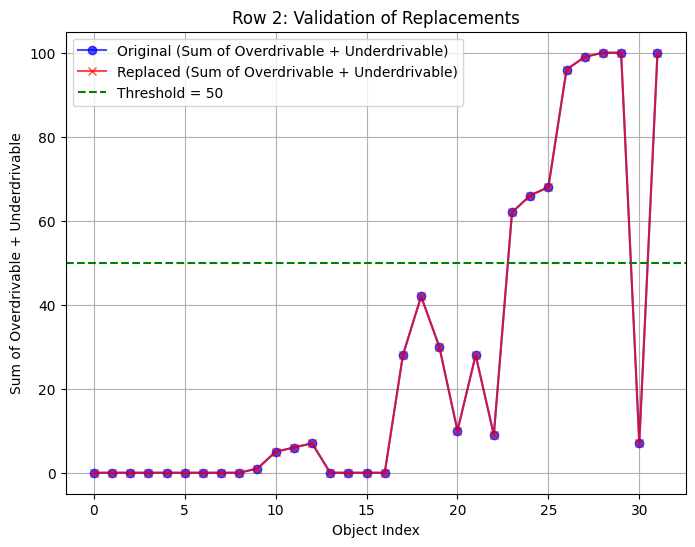


Row 3 - Condition Validation:
  Object 23 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 0, Underdrivable: 57
    Replaced Overdrivable: 0, Underdrivable: 57
    Column: rcs, Original Value: -2, Replaced Value: -2
    Column: distance, Original Value: 11.170000076293945, Replaced Value: 11.170000076293945
    Column: angleAzimuth, Original Value: 0.4015480875968933, Replaced Value: 0.4015480875968933
    Column: angleElevation, Original Value: -0.044924795627593994, Replaced Value: -0.044924795627593994
    Column: radialVelocity, Original Value: 0.06499999761581421, Replaced Value: 0.06499999761581421
    Column: orientation, Original Value: 0.0, Replaced Value: 0.0
    Column: x, Original Value: 55.55999755859375, Replaced Value: 55.55999755859375
    Column: y, Original Value: 8.84999942779541, Replaced Value: 8.84999942779541
    Column: width_edge_mean, Original Value: 2.859999895095825, Replaced Value: 2.859999895095825
    Column: length_edge_mean, Origina

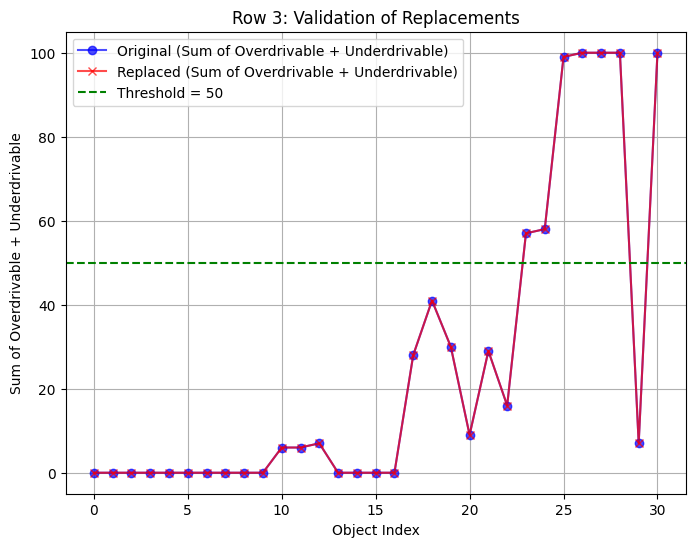


Row 4 - Condition Validation:
  Object 22 (Invalid `overdrivable + underdrivable`):
    Original Overdrivable: 15, Underdrivable: 55
    Replaced Overdrivable: 15, Underdrivable: 55
    Column: rcs, Original Value: -23, Replaced Value: -23
    Column: distance, Original Value: 10.449999809265137, Replaced Value: 10.449999809265137
    Column: angleAzimuth, Original Value: 0.426104873418808, Replaced Value: 0.426104873418808
    Column: angleElevation, Original Value: -0.07162834703922272, Replaced Value: -0.07162834703922272
    Column: radialVelocity, Original Value: 0.009999999776482582, Replaced Value: 0.009999999776482582
    Column: orientation, Original Value: 1.2407402992248535, Replaced Value: 1.2407402992248535
    Column: x, Original Value: 55.2599983215332, Replaced Value: 55.2599983215332
    Column: y, Original Value: 14.069999694824219, Replaced Value: 14.069999694824219
    Column: width_edge_mean, Original Value: 0.3499999940395355, Replaced Value: 0.3499999940395355
 

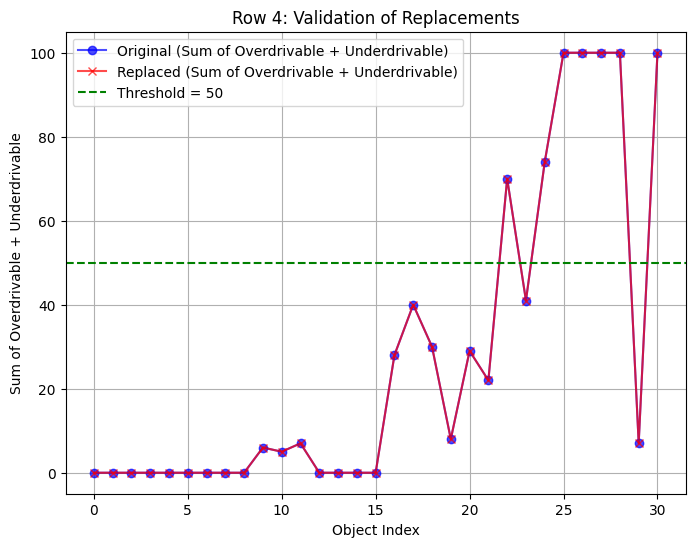

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def validate_conditions_with_columns(file_path_original, file_path_replaced, columns_to_check, rows_to_check=5):
    """
    Validates the following conditions:
    1. `overdrivable + underdrivable > 50` replaced correctly.
    2. `status_measurement == (0, 'measured')` condition applied.
    3. `status_movement == (0, 'moved')` condition applied.

    Compares original and replaced values across specified columns and visualizes results.
    """
    # Load original and replaced data
    original_data = pd.read_pickle(file_path_original)
    replaced_data = pd.read_pickle(file_path_replaced)

    print("\n--- Validating Conditions and Related Columns ---")

    for idx, (orig_row, repl_row) in enumerate(zip(original_data.iterrows(), replaced_data.iterrows())):
        if idx >= rows_to_check:
            break

        orig_row = orig_row[1]
        repl_row = repl_row[1]

        try:
            # Extract conditions
            orig_overdrivable = orig_row["overdrivable"]
            orig_underdrivable = orig_row["underdrivable"]
            repl_overdrivable = repl_row["overdrivable"]
            repl_underdrivable = repl_row["underdrivable"]

            orig_status_measurement = orig_row["status_measurement"]
            repl_status_measurement = repl_row["status_measurement"]

            orig_status_movement = orig_row["status_movement"]
            repl_status_movement = repl_row["status_movement"]

            # Convert to lists for uniform comparison
            if not isinstance(orig_overdrivable, list):
                orig_overdrivable = list(orig_overdrivable)
            if not isinstance(orig_underdrivable, list):
                orig_underdrivable = list(orig_underdrivable)
            if not isinstance(repl_overdrivable, list):
                repl_overdrivable = list(repl_overdrivable)
            if not isinstance(repl_underdrivable, list):
                repl_underdrivable = list(repl_underdrivable)

            invalid_indices = [
                i for i in range(len(orig_overdrivable))
                if orig_overdrivable[i] + orig_underdrivable[i] > 50
            ]

            print(f"\nRow {idx} - Condition Validation:")
            for i in invalid_indices[:5]:  # Show only the first 5 invalid objects
                print(f"  Object {i} (Invalid `overdrivable + underdrivable`):")
                print(f"    Original Overdrivable: {orig_overdrivable[i]}, Underdrivable: {orig_underdrivable[i]}")
                print(f"    Replaced Overdrivable: {repl_overdrivable[i]}, Underdrivable: {repl_underdrivable[i]}")
                for col in columns_to_check:
                    orig_value = orig_row[col][i] if i < len(orig_row[col]) else None
                    repl_value = repl_row[col][i] if i < len(repl_row[col]) else None
                    print(f"    Column: {col}, Original Value: {orig_value}, Replaced Value: {repl_value}")

            measured_indices = [
                i for i in range(len(orig_status_measurement))
                if orig_status_measurement[i] != (0, "measured")
            ]

            for i in measured_indices[:5]:  # Show only the first 5 invalid objects
                print(f"  Object {i} (Invalid `status_measurement`):")
                print(f"    Original Status: {orig_status_measurement[i]}")
                print(f"    Replaced Status: {repl_status_measurement[i]}")
                for col in columns_to_check:
                    orig_value = orig_row[col][i] if i < len(orig_row[col]) else None
                    repl_value = repl_row[col][i] if i < len(repl_row[col]) else None
                    print(f"    Column: {col}, Original Value: {orig_value}, Replaced Value: {repl_value}")

            moved_indices = [
                i for i in range(len(orig_status_movement))
                if orig_status_movement[i] != (0, "moved")
            ]

            for i in moved_indices[:5]:  # Show only the first 5 invalid objects
                print(f"  Object {i} (Invalid `status_movement`):")
                print(f"    Original Status: {orig_status_movement[i]}")
                print(f"    Replaced Status: {repl_status_movement[i]}")
                for col in columns_to_check:
                    orig_value = orig_row[col][i] if i < len(orig_row[col]) else None
                    repl_value = repl_row[col][i] if i < len(repl_row[col]) else None
                    print(f"    Column: {col}, Original Value: {orig_value}, Replaced Value: {repl_value}")

            # Visualization
            plt.figure(figsize=(8, 6))
            plt.plot(
                range(len(orig_overdrivable)),
                [orig_overdrivable[i] + orig_underdrivable[i] for i in range(len(orig_overdrivable))],
                label="Original (Sum of Overdrivable + Underdrivable)",
                marker="o",
                alpha=0.7,
                color="blue",
            )
            plt.plot(
                range(len(repl_overdrivable)),
                [repl_overdrivable[i] + repl_underdrivable[i] for i in range(len(repl_overdrivable))],
                label="Replaced (Sum of Overdrivable + Underdrivable)",
                marker="x",
                alpha=0.7,
                color="red",
            )
            plt.title(f"Row {idx}: Validation of Replacements")
            plt.xlabel("Object Index")
            plt.ylabel("Sum of Overdrivable + Underdrivable")
            plt.axhline(50, color="green", linestyle="--", label="Threshold = 50")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error validating row {idx}: {e}")

# File paths for validation
file_path_original = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\combined_frr40_detections_0.p"
file_path_replaced = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\zeroed_combined_frr40_detections_0.p"

# Columns to check for respective values
columns_to_check = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean"
]

# Run validation
validate_conditions_with_columns(file_path_original, file_path_replaced, columns_to_check, rows_to_check=5)


In [32]:
import pandas as pd

# Load the dataset
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_zeroed_combined_frr40_detections_0.p"
df = pd.read_pickle(file_path)

# Specify relevant columns
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Check if all columns exist in the DataFrame
existing_columns = [col for col in relevant_columns if col in df.columns]

# Print data types of relevant columns
print("\n--- Data Types of Relevant Columns ---")
print(df[existing_columns].dtypes)

# Show a sample of rows for inspection
print("\n--- Sample Rows from Relevant Columns ---")
print(df[existing_columns].head(10))

# Check for any missing or inconsistent data
print("\n--- Checking for Missing Values in Relevant Columns ---")
print(df[existing_columns].isnull().sum())



--- Data Types of Relevant Columns ---
rcs                 object
distance            object
angleAzimuth        object
angleElevation      object
radialVelocity      object
orientation         object
x                   object
y                   object
width_edge_mean     object
length_edge_mean    object
transformed_x       object
transformed_y       object
centroids           object
dtype: object

--- Sample Rows from Relevant Columns ---
                                                 rcs  \
0  [8, 12, -13, -22, -7, -2, -18, -24, -14, 11, -...   
1  [7, -15, 11, -7, -3, -17, -26, -23, -32, -15, ...   
2  [8, -12, -18, -7, -3, -18, -23, -5, -16, 4, -2...   
3  [8, 7, -17, 18, -28, -18, -2, -24, -14, -3, 11...   
4  [6, -4, -17, 18, 2, -2, -3, -16, -23, -27, -14...   
5  [8, -4, 3, -15, 17, -15, -3, -17, -23, -2, -12...   
6  [-47, 30, -5, -17, 3, 17, -26, -15, -8, -23, -...   
7  [5, -5, -14, 17, -3, -25, -16, -26, -30, -11, ...   
8  [5, -5, -16, 14, -25, -14, -24, -24, -15, -10

In [37]:
# Ensure relevant and condition columns are in list format
def ensure_list_format(dataframe, columns):
    """
    Converts specified columns to list format if not already in that format.
    """
    for col in columns:
        if col in dataframe.columns:
            dataframe[col] = dataframe[col].apply(lambda x: x if isinstance(x, list) else [])
    return dataframe

# Example usage
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_zeroed_combined_frr40_detections_0.p"
df = pd.read_pickle(file_path)

relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity", 
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean", 
    "transformed_x", "transformed_y", "centroids"
]
condition_columns = ["overdrivable", "underdrivable", "status_measurement", "status_movement"]

# Convert columns to list format
df = ensure_list_format(df, relevant_columns + condition_columns)

# Inspect data
print(df.head())


      timestamp rcs distance angleAzimuth angleElevation radialVelocity  \
0  2.739721e+07  []       []           []             []             []   
1  2.739721e+07  []       []           []             []             []   
2  2.739721e+07  []       []           []             []             []   
3  2.739721e+07  []       []           []             []             []   
4  2.739721e+07  []       []           []             []             []   

   radialVelocityDomainMax orientation   x   y  ... header.origin.z  \
0                25.593336          []  []  []  ...           0.679   
1                23.288147          []  []  []  ...           0.679   
2                28.015123          []  []  []  ...           0.679   
3                24.840691          []  []  []  ...           0.679   
4                23.058084          []  []  []  ...           0.679   

  header.origin.roll header.origin.pitch header.origin.yaw  yaw_rate  \
0                0.0                 0.0          

In [38]:
import pandas as pd

# Load the dataset
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p"
df = pd.read_pickle(file_path)

# Relevant columns to check
columns_to_check = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Check if columns are empty or contain values
for col in columns_to_check:
    if col in df.columns:
        non_empty_count = df[col].apply(lambda x: len(x) > 0 if isinstance(x, list) else False).sum()
        print(f"Column: {col}, Non-Empty Rows: {non_empty_count}, Total Rows: {len(df)}")
    else:
        print(f"Column: {col} is missing in the DataFrame.")


Column: rcs, Non-Empty Rows: 0, Total Rows: 632
Column: distance, Non-Empty Rows: 0, Total Rows: 632
Column: angleAzimuth, Non-Empty Rows: 0, Total Rows: 632
Column: angleElevation, Non-Empty Rows: 0, Total Rows: 632
Column: radialVelocity, Non-Empty Rows: 0, Total Rows: 632
Column: orientation, Non-Empty Rows: 0, Total Rows: 632
Column: x, Non-Empty Rows: 0, Total Rows: 632
Column: y, Non-Empty Rows: 0, Total Rows: 632
Column: width_edge_mean, Non-Empty Rows: 0, Total Rows: 632
Column: length_edge_mean, Non-Empty Rows: 0, Total Rows: 632
Column: transformed_x, Non-Empty Rows: 632, Total Rows: 632
Column: transformed_y, Non-Empty Rows: 632, Total Rows: 632
Column: centroids is missing in the DataFrame.


In [39]:
import pandas as pd

# Load the dataset
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p"
df = pd.read_pickle(file_path)

# Print the `rcs` column
print("--- RCS Column ---")
print(df["rcs"].head(10))  # Print first 10 rows of the `rcs` column


--- RCS Column ---
0    [8, 12, -13, -22, -7, -2, -18, -24, -14, 11, -...
1    [7, -15, 11, -7, -3, -17, -26, -23, -32, -15, ...
2    [8, -12, -18, -7, -3, -18, -23, -5, -16, 4, -2...
3    [8, 7, -17, 18, -28, -18, -2, -24, -14, -3, 11...
4    [6, -4, -17, 18, 2, -2, -3, -16, -23, -27, -14...
5    [8, -4, 3, -15, 17, -15, -3, -17, -23, -2, -12...
6    [-47, 30, -5, -17, 3, 17, -26, -15, -8, -23, -...
7    [5, -5, -14, 17, -3, -25, -16, -26, -30, -11, ...
8    [5, -5, -16, 14, -25, -14, -24, -24, -15, -10,...
9    [33, 5, -5, 10, 13, 1, -31, -15, -20, -27, -31...
Name: rcs, dtype: object


In [40]:
import pandas as pd

# Path to the file
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\transformed_zeroed_combined_frr40_detections_0.p"

# Load the DataFrame
df = pd.read_pickle(file_path)

# Columns to validate
columns_to_check = [
    "rcs", "distance", "angleAzimuth", "angleElevation",
    "radialVelocity", "orientation", "x", "y", "width_edge_mean",
    "length_edge_mean", "transformed_x", "transformed_y", "centroids"
]

print("--- Validating Non-Empty Rows in Relevant Columns ---")
for col in columns_to_check:
    if col in df.columns:
        non_empty_count = df[col].apply(lambda x: len(x) if isinstance(x, list) else 0).sum()
        print(f"Column: {col}, Non-Empty Objects: {non_empty_count}")
    else:
        print(f"Column: {col} is missing from the DataFrame.")


--- Validating Non-Empty Rows in Relevant Columns ---
Column: rcs, Non-Empty Objects: 0
Column: distance, Non-Empty Objects: 0
Column: angleAzimuth, Non-Empty Objects: 0
Column: angleElevation, Non-Empty Objects: 0
Column: radialVelocity, Non-Empty Objects: 0
Column: orientation, Non-Empty Objects: 0
Column: x, Non-Empty Objects: 0
Column: y, Non-Empty Objects: 0
Column: width_edge_mean, Non-Empty Objects: 0
Column: length_edge_mean, Non-Empty Objects: 0
Column: transformed_x, Non-Empty Objects: 30661
Column: transformed_y, Non-Empty Objects: 30661
Column: centroids is missing from the DataFrame.


In [44]:
import pandas as pd
import numpy as np

# File path for the dataset
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\centroid_transformed_zeroed_combined_frr40_detections_0.p"

# Load the data
df = pd.read_pickle(file_path)

# Columns to process
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to safely convert column values to a list format
def convert_to_list_format(value):
    try:
        if isinstance(value, list):
            return value
        elif isinstance(value, (np.ndarray, pd.Series)):
            return value.tolist()
        elif value is None or pd.isna(value):  # Handle NaN or None
            return []
        else:
            return [value]  # Wrap scalar values in a list
    except Exception as e:
        print(f"Error converting value: {value}. Error: {e}")
        return []

# Convert relevant columns to list format
for col in relevant_columns:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: convert_to_list_format(x))

# Save the data with converted formats for consistency
output_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p"
df.to_pickle(output_path)

print(f"Relevant columns converted to suitable format and saved to: {output_path}")

# Display some rows to verify
print("--- Sample Rows After Conversion ---")
print(df[relevant_columns].head())


Relevant columns converted to suitable format and saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p
--- Sample Rows After Conversion ---
                                                 rcs  \
0  [8, 12, -13, -22, -7, -2, -18, -24, -14, 11, -...   
1  [7, -15, 11, -7, -3, -17, -26, -23, -32, -15, ...   
2  [8, -12, -18, -7, -3, -18, -23, -5, -16, 4, -2...   
3  [8, 7, -17, 18, -28, -18, -2, -24, -14, -3, 11...   
4  [6, -4, -17, 18, 2, -2, -3, -16, -23, -27, -14...   

                                            distance  \
0  [3.629999876022339, 4.039999961853027, 4.11999...   
1  [3.619999885559082, 4.130000114440918, 4.52999...   
2  [3.619999885559082, 4.130000114440918, 4.28999...   
3  [3.6399998664855957, 3.68999981880188, 4.11000...   
4  [3.6599998474121094, 3.869999885559082, 4.2699...   

                                        angleAzimuth  \
0  [-0.13927733898162842, -0.005183630157262087, ...   
1 

In [52]:
import pandas as pd

# File paths
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p"
output_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load the dataset
df = pd.read_pickle(file_path)

# Relevant columns
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Replacement function for each row
def replace_invalid_objects(row):
    # Extract conditions
    overdrivable = row.get("overdrivable", [])
    underdrivable = row.get("underdrivable", [])
    status_measurement = row.get("status_measurement", [])
    status_movement = row.get("status_movement", [])

    # Iterate through the lists in relevant columns and apply conditions
    for i in range(len(overdrivable)):
        # Check if object is invalid
        is_invalid = (
            overdrivable[i] + underdrivable[i] > 50 or
            status_measurement[i] != "measured" or
            status_movement[i] not in [0, "moved"]
        )
        
        # Replace invalid objects in relevant columns with 0
        if is_invalid:
            for col in relevant_columns:
                if col in row and isinstance(row[col], list) and i < len(row[col]):
                    row[col][i] = 0  # Replace value at the same index
    
    return row

# Apply the function to the dataframe
df = df.apply(replace_invalid_objects, axis=1)

# Save the updated dataframe
df.to_pickle(output_path)

print(f"Invalid objects replaced and saved to: {output_path}")


Invalid objects replaced and saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p


In [53]:
import pandas as pd

# File paths
original_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p"
cleaned_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load original and cleaned datasets
original_df = pd.read_pickle(original_path)
cleaned_df = pd.read_pickle(cleaned_path)

# Relevant columns
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to compare rows and find replaced values
def validate_replacements(original_row, cleaned_row):
    replaced = {}
    for col in relevant_columns:
        if col in original_row and col in cleaned_row:
            # Compare original and cleaned lists
            original_list = original_row[col]
            cleaned_list = cleaned_row[col]
            if isinstance(original_list, list) and isinstance(cleaned_list, list):
                for i, (orig, clean) in enumerate(zip(original_list, cleaned_list)):
                    if orig != clean and clean == 0:  # Check if value was replaced with 0
                        if col not in replaced:
                            replaced[col] = []
                        replaced[col].append((i, orig, clean))  # Store index and values
    return replaced

# Iterate and validate
replacements = []
for idx in range(len(original_df)):
    replaced = validate_replacements(original_df.iloc[idx], cleaned_df.iloc[idx])
    if replaced:
        replacements.append((idx, replaced))

# Display a sample of replaced rows
sample_size = min(5, len(replacements))  # Show up to 5 examples
print(f"Found {len(replacements)} rows with replaced values. Showing {sample_size} examples:")
for i in range(sample_size):
    row_idx, replaced_data = replacements[i]
    print(f"\nRow {row_idx}:")
    for col, changes in replaced_data.items():
        print(f"  Column: {col}")
        for index, original, replaced in changes:
            print(f"    Object Index: {index}, Original: {original}, Replaced: {replaced}")


Found 632 rows with replaced values. Showing 5 examples:

Row 0:
  Column: rcs
    Object Index: 0, Original: 8, Replaced: 0
    Object Index: 1, Original: 12, Replaced: 0
    Object Index: 2, Original: -13, Replaced: 0
    Object Index: 3, Original: -22, Replaced: 0
    Object Index: 4, Original: -7, Replaced: 0
    Object Index: 5, Original: -2, Replaced: 0
    Object Index: 6, Original: -18, Replaced: 0
    Object Index: 7, Original: -24, Replaced: 0
    Object Index: 8, Original: -14, Replaced: 0
    Object Index: 9, Original: 11, Replaced: 0
    Object Index: 10, Original: -2, Replaced: 0
    Object Index: 11, Original: -19, Replaced: 0
    Object Index: 12, Original: -16, Replaced: 0
    Object Index: 13, Original: -14, Replaced: 0
    Object Index: 14, Original: -7, Replaced: 0
    Object Index: 15, Original: 6, Replaced: 0
    Object Index: 16, Original: -13, Replaced: 0
    Object Index: 17, Original: -17, Replaced: 0
    Object Index: 18, Original: -23, Replaced: 0
    Object

In [8]:
import pandas as pd

# File paths
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p"
output_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load data
df = pd.read_pickle(file_path)

# Relevant columns to modify
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to check object validity
def is_object_valid(overdrivable, underdrivable, measurement, movement):
    """Determine if an object is valid based on the given conditions."""
    return (
        (sum(overdrivable) + sum(underdrivable) <= 50) and  # Condition 1
        (measurement == "measured") and                    # Condition 2
        (movement in [0, "moved"])                         # Condition 3
    )

# Function to clean invalid objects in a row
def clean_invalid_objects(row):
    overdrivable = row.get("overdrivable", [])
    underdrivable = row.get("underdrivable", [])
    measurement = row.get("status_measurement", [])
    movement = row.get("status_movement", [])

    # Iterate through objects in the row
    for i in range(len(overdrivable)):
        if not is_object_valid(
            [overdrivable[i]], [underdrivable[i]], 
            measurement[i], movement[i]
        ):
            # Replace invalid object in all relevant columns
            for col in relevant_columns:
                if col in row:
                    if col == "centroids":
                        row[col][i] = (0, 0)  # Replace centroids with (0, 0)
                    else:
                        row[col][i] = 0  # Replace other values with 0
    return row

# Apply cleaning function to all rows
df = df.apply(clean_invalid_objects, axis=1)

# Save the cleaned DataFrame
df.to_pickle(output_path)
print(f"Cleaned data saved to: {output_path}")


Cleaned data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p


In [9]:
import pandas as pd

# File paths
original_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p"
cleaned_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load original and cleaned DataFrames
original_df = pd.read_pickle(original_path)
cleaned_df = pd.read_pickle(cleaned_path)

# Relevant columns to validate
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to validate replacements
def validate_replacements(original_row, cleaned_row):
    replaced = {}
    for col in relevant_columns:
        if col in original_row and col in cleaned_row:
            original_list = original_row[col]
            cleaned_list = cleaned_row[col]

            # Ensure both columns contain lists
            if isinstance(original_list, list) and isinstance(cleaned_list, list):
                # Compare individual objects
                for i, (orig, clean) in enumerate(zip(original_list, cleaned_list)):
                    if col == "centroids":
                        # Check if centroids were replaced with (0, 0)
                        if orig != clean and clean == (0, 0):
                            if col not in replaced:
                                replaced[col] = []
                            replaced[col].append((i, orig, clean))
                    else:
                        # Check if values were replaced with 0
                        if orig != clean and clean == 0:
                            if col not in replaced:
                                replaced[col] = []
                            replaced[col].append((i, orig, clean))
    return replaced

# Iterate through rows and validate
replacements = []
for idx in range(len(original_df)):
    replaced_data = validate_replacements(original_df.iloc[idx], cleaned_df.iloc[idx])
    if replaced_data:
        replacements.append((idx, replaced_data))

# Display validation results
sample_size = min(5, len(replacements))  # Limit output to 5 rows
print(f"Found {len(replacements)} rows with replacements. Showing {sample_size} examples:")

for i in range(sample_size):
    row_idx, replaced = replacements[i]
    print(f"\nRow {row_idx}:")
    for col, changes in replaced.items():
        print(f"  Column: {col}")
        for index, original, replaced_value in changes:
            print(f"    Object Index: {index}, Original: {original}, Replaced: {replaced_value}")

# Validate list lengths before and after cleaning
length_issues = []
for idx in range(len(original_df)):
    for col in relevant_columns:
        if col in original_df.columns and col in cleaned_df.columns:
            original_list = original_df.iloc[idx][col]
            cleaned_list = cleaned_df.iloc[idx][col]

            if isinstance(original_list, list) and isinstance(cleaned_list, list):
                if len(original_list) != len(cleaned_list):
                    length_issues.append((idx, col, len(original_list), len(cleaned_list)))

# Display list length validation
if length_issues:
    print("\nList Length Issues Detected:")
    for idx, col, orig_len, clean_len in length_issues:
        print(f"  Row {idx}, Column: {col}, Original Length: {orig_len}, Cleaned Length: {clean_len}")
else:
    print("\nAll list lengths are consistent before and after cleaning.")


Found 632 rows with replacements. Showing 5 examples:

Row 0:
  Column: rcs
    Object Index: 0, Original: 8, Replaced: 0
    Object Index: 1, Original: 12, Replaced: 0
    Object Index: 2, Original: -13, Replaced: 0
    Object Index: 3, Original: -22, Replaced: 0
    Object Index: 4, Original: -7, Replaced: 0
    Object Index: 5, Original: -2, Replaced: 0
    Object Index: 6, Original: -18, Replaced: 0
    Object Index: 7, Original: -24, Replaced: 0
    Object Index: 8, Original: -14, Replaced: 0
    Object Index: 9, Original: 11, Replaced: 0
    Object Index: 10, Original: -2, Replaced: 0
    Object Index: 11, Original: -19, Replaced: 0
    Object Index: 12, Original: -16, Replaced: 0
    Object Index: 13, Original: -14, Replaced: 0
    Object Index: 14, Original: -7, Replaced: 0
    Object Index: 15, Original: 6, Replaced: 0
    Object Index: 16, Original: -13, Replaced: 0
    Object Index: 17, Original: -17, Replaced: 0
    Object Index: 18, Original: -23, Replaced: 0
    Object In

In [3]:
import pandas as pd

# File paths
cleaned_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load cleaned DataFrame
cleaned_df = pd.read_pickle(cleaned_path)

# Relevant columns to check
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to extract valid objects
def extract_valid_objects(row):
    valid_objects = {}
    for col in relevant_columns:
        if col in row:
            values = row[col]
            if isinstance(values, list):
                # Identify valid (non-zero) objects
                valid = [(i, val) for i, val in enumerate(values) if val != 0 and val != (0, 0)]
                if valid:
                    valid_objects[col] = valid
    return valid_objects

# Iterate through rows and extract valid objects
valid_objects_summary = []
for idx, row in cleaned_df.iterrows():
    valid_objects = extract_valid_objects(row)
    if valid_objects:
        valid_objects_summary.append((idx, valid_objects))

# Display valid objects
sample_size = min(5, len(valid_objects_summary))  # Limit output to 5 rows
print(f"Found {len(valid_objects_summary)} rows with valid objects. Showing {sample_size} examples:")

for i in range(sample_size):
    row_idx, valid_objects = valid_objects_summary[i]
    print(f"\nRow {row_idx}:")
    for col, valid_data in valid_objects.items():
        print(f"  Column: {col}")
        for index, value in valid_data:
            print(f"    Object Index: {index}, Value: {value}")


Found 632 rows with valid objects. Showing 5 examples:

Row 0:
  Column: rcs
    Object Index: 36, Value: -10
    Object Index: 37, Value: 29
    Object Index: 38, Value: 4
    Object Index: 39, Value: -14
    Object Index: 40, Value: -14
    Object Index: 41, Value: -24
    Object Index: 42, Value: -24
    Object Index: 43, Value: -22
    Object Index: 44, Value: -23
    Object Index: 45, Value: -23
    Object Index: 46, Value: -20
    Object Index: 47, Value: 2
    Object Index: 48, Value: -15
    Object Index: 49, Value: -23
    Object Index: 50, Value: -14
    Object Index: 51, Value: -19
    Object Index: 52, Value: -14
    Object Index: 53, Value: 10
    Object Index: 54, Value: -16
    Object Index: 55, Value: -29
    Object Index: 56, Value: -23
    Object Index: 57, Value: -30
    Object Index: 58, Value: -27
    Object Index: 59, Value: -16
    Object Index: 60, Value: -7
    Object Index: 61, Value: -27
    Object Index: 62, Value: 1
    Object Index: 63, Value: -17
    Obje

In [10]:
import pandas as pd

# File paths
original_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p"
cleaned_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load original and cleaned DataFrames
original_df = pd.read_pickle(original_path)
cleaned_df = pd.read_pickle(cleaned_path)

# Relevant columns to validate
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# 1. Validate replaced objects
def validate_replacements(original_row, cleaned_row):
    replaced = {}
    for col in relevant_columns:
        if col in original_row and col in cleaned_row:
            original_list = original_row[col]
            cleaned_list = cleaned_row[col]

            # Ensure both columns contain lists
            if isinstance(original_list, list) and isinstance(cleaned_list, list):
                # Compare individual objects
                for i, (orig, clean) in enumerate(zip(original_list, cleaned_list)):
                    if col == "centroids":
                        # Check if centroids were replaced with (0, 0)
                        if orig != clean and clean == (0, 0):
                            if col not in replaced:
                                replaced[col] = []
                            replaced[col].append((i, orig, clean))
                    else:
                        # Check if values were replaced with 0
                        if orig != clean and clean == 0:
                            if col not in replaced:
                                replaced[col] = []
                            replaced[col].append((i, orig, clean))
    return replaced

# Iterate through rows and validate replacements
replacements = []
for idx in range(len(original_df)):
    replaced_data = validate_replacements(original_df.iloc[idx], cleaned_df.iloc[idx])
    if replaced_data:
        replacements.append((idx, replaced_data))

# Display replaced objects
print(f"Found {len(replacements)} rows with replaced values. Showing 5 examples:")
for i in range(min(5, len(replacements))):  # Show only 5 examples
    row_idx, replaced = replacements[i]
    print(f"\nRow {row_idx}:")
    for col, changes in replaced.items():
        print(f"  Column: {col}")
        for index, original, replaced_value in changes:
            print(f"    Object Index: {index}, Original: {original}, Replaced: {replaced_value}")

# 2. Validate valid objects
def extract_valid_objects(row):
    valid_objects = {}
    for col in relevant_columns:
        if col in row:
            values = row[col]
            if isinstance(values, list):
                # Identify valid (non-zero) objects
                valid = [(i, val) for i, val in enumerate(values) if val != 0 and val != (0, 0)]
                if valid:
                    valid_objects[col] = valid
    return valid_objects

# Iterate through rows and extract valid objects
valid_objects_summary = []
for idx, row in cleaned_df.iterrows():
    valid_objects = extract_valid_objects(row)
    if valid_objects:
        valid_objects_summary.append((idx, valid_objects))

# Display valid objects
print(f"\nFound {len(valid_objects_summary)} rows with valid objects. Showing 5 examples:")
for i in range(min(5, len(valid_objects_summary))):  # Show only 5 examples
    row_idx, valid_objects = valid_objects_summary[i]
    print(f"\nRow {row_idx}:")
    for col, valid_data in valid_objects.items():
        print(f"  Column: {col}")
        for index, value in valid_data:
            print(f"    Object Index: {index}, Value: {value}")

# 3. Validate list lengths
length_issues = []
for idx in range(len(original_df)):
    for col in relevant_columns:
        if col in original_df.columns and col in cleaned_df.columns:
            original_list = original_df.iloc[idx][col]
            cleaned_list = cleaned_df.iloc[idx][col]

            if isinstance(original_list, list) and isinstance(cleaned_list, list):
                if len(original_list) != len(cleaned_list):
                    length_issues.append((idx, col, len(original_list), len(cleaned_list)))

# Display list length validation
if length_issues:
    print("\nList Length Issues Detected:")
    for idx, col, orig_len, clean_len in length_issues:
        print(f"  Row {idx}, Column: {col}, Original Length: {orig_len}, Cleaned Length: {clean_len}")
else:
    print("\nAll list lengths are consistent before and after cleaning.")


Found 632 rows with replaced values. Showing 5 examples:

Row 0:
  Column: rcs
    Object Index: 0, Original: 8, Replaced: 0
    Object Index: 1, Original: 12, Replaced: 0
    Object Index: 2, Original: -13, Replaced: 0
    Object Index: 3, Original: -22, Replaced: 0
    Object Index: 4, Original: -7, Replaced: 0
    Object Index: 5, Original: -2, Replaced: 0
    Object Index: 6, Original: -18, Replaced: 0
    Object Index: 7, Original: -24, Replaced: 0
    Object Index: 8, Original: -14, Replaced: 0
    Object Index: 9, Original: 11, Replaced: 0
    Object Index: 10, Original: -2, Replaced: 0
    Object Index: 11, Original: -19, Replaced: 0
    Object Index: 12, Original: -16, Replaced: 0
    Object Index: 13, Original: -14, Replaced: 0
    Object Index: 14, Original: -7, Replaced: 0
    Object Index: 15, Original: 6, Replaced: 0
    Object Index: 16, Original: -13, Replaced: 0
    Object Index: 17, Original: -17, Replaced: 0
    Object Index: 18, Original: -23, Replaced: 0
    Object

In [12]:
import pandas as pd

# File paths
original_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p"
cleaned_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load original and cleaned datasets
original_df = pd.read_pickle(original_path)
cleaned_df = pd.read_pickle(cleaned_path)

# Relevant columns
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to compare rows and find replaced values
def validate_replacements(original_row, cleaned_row, index):
    replaced = {}
    conditions = []
    for col in relevant_columns:
        if col in original_row and col in cleaned_row:
            # Compare original and cleaned lists
            original_list = original_row[col]
            cleaned_list = cleaned_row[col]
            if isinstance(original_list, list) and isinstance(cleaned_list, list):
                for i, (orig, clean) in enumerate(zip(original_list, cleaned_list)):
                    if orig != clean and clean == 0:  # Check if value was replaced with 0
                        if col not in replaced:
                            replaced[col] = []
                        replaced[col].append((i, orig, clean))  # Store index and values
                        # Collect replacement condition
                        if col == "rcs" and i < len(original_row["overdrivable"]):
                            if original_row["overdrivable"][i] + original_row["underdrivable"][i] > 50:
                                conditions.append(f"Condition: Overdrivable + Underdrivable > 50 at index {i}")
                        if col == "rcs" and i < len(original_row["status_movement"]):
                            if original_row["status_movement"][i] not in [0, "moved"]:
                                conditions.append(f"Condition: Invalid Movement at index {i}")
                        if col == "rcs" and i < len(original_row["status_measurement"]):
                            if original_row["status_measurement"][i] != "measured":
                                conditions.append(f"Condition: Not Measured at index {i}")
    return replaced, conditions

# Iterate and validate
replacements = []
for idx in range(len(original_df)):
    replaced, conditions = validate_replacements(original_df.iloc[idx], cleaned_df.iloc[idx], idx)
    if replaced:
        replacements.append((idx, replaced, conditions))

# Display replaced rows
sample_size = min(5, len(replacements))  # Show up to 5 examples
print(f"Found {len(replacements)} rows with replaced values. Showing {sample_size} examples:\n")
for i in range(sample_size):
    row_idx, replaced_data, conditions = replacements[i]
    print(f"Row {row_idx}:")
    print(f"  Conditions for Replacement: {conditions}")
    print(f"  Old Row Data:")
    print(original_df.iloc[row_idx][relevant_columns])
    print(f"  New Row Data:")
    print(cleaned_df.iloc[row_idx][relevant_columns])
    for col, changes in replaced_data.items():
        print(f"  Column: {col}")
        for index, original, replaced in changes:
            print(f"    Object Index: {index}, Original: {original}, Replaced: {replaced}")


Found 632 rows with replaced values. Showing 5 examples:

Row 0:
  Conditions for Replacement: ['Condition: Invalid Movement at index 0', 'Condition: Not Measured at index 0', 'Condition: Invalid Movement at index 1', 'Condition: Not Measured at index 1', 'Condition: Invalid Movement at index 2', 'Condition: Not Measured at index 2', 'Condition: Invalid Movement at index 3', 'Condition: Not Measured at index 3', 'Condition: Invalid Movement at index 4', 'Condition: Not Measured at index 4', 'Condition: Invalid Movement at index 5', 'Condition: Not Measured at index 5', 'Condition: Invalid Movement at index 6', 'Condition: Not Measured at index 6', 'Condition: Invalid Movement at index 7', 'Condition: Not Measured at index 7', 'Condition: Invalid Movement at index 8', 'Condition: Not Measured at index 8', 'Condition: Invalid Movement at index 9', 'Condition: Not Measured at index 9', 'Condition: Invalid Movement at index 10', 'Condition: Not Measured at index 10', 'Condition: Invalid Mo

In [14]:
import pandas as pd

# File paths
file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p"
output_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load data
df = pd.read_pickle(file_path)

# Relevant columns to modify
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to check object validity
def is_object_valid(overdrivable, underdrivable, measurement, movement):
    """
    Determine if an object is valid based on the given conditions:
    1. Sum of overdrivable + underdrivable ≤ 50
    2. Measurement is 'measured'
    3. Movement is either 0 or 'moved'
    """
    return (
        (overdrivable + underdrivable <= 50) and  # Condition 1
        (measurement == "measured") and          # Condition 2
        (movement in [0, "moved"])               # Condition 3
    )

# Function to clean invalid objects in a row
def clean_invalid_objects(row):
    overdrivable = row.get("overdrivable", [])
    underdrivable = row.get("underdrivable", [])
    measurement = row.get("status_measurement", [])
    movement = row.get("status_movement", [])

    # Ensure all columns are aligned and retain their original positions
    num_objects = len(overdrivable)  # Total objects in the row
    for i in range(num_objects):
        # Check if the object is valid
        if not is_object_valid(
            overdrivable[i], underdrivable[i], 
            measurement[i], movement[i]
        ):
            # Replace invalid object in all relevant columns
            for col in relevant_columns:
                if col in row and len(row[col]) > i:
                    if col == "centroids":
                        row[col][i] = (0, 0)  # Replace centroids with (0, 0)
                    else:
                        row[col][i] = 0  # Replace other values with 0
    return row

# Apply cleaning function to all rows
df = df.apply(clean_invalid_objects, axis=1)

# Save the cleaned DataFrame
df.to_pickle(output_path)
print(f"Cleaned data saved to: {output_path}")


Cleaned data saved to: C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p


In [15]:
import pandas as pd

# File paths
original_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\converted_transformed_zeroed_combined_frr40_detections_0.p"
cleaned_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load original and cleaned datasets
original_df = pd.read_pickle(original_path)
cleaned_df = pd.read_pickle(cleaned_path)

# Relevant columns
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to validate replacements
def validate_replacements(original_row, cleaned_row):
    replaced = {}
    for col in relevant_columns:
        if col in original_row and col in cleaned_row:
            # Compare original and cleaned lists
            original_list = original_row[col]
            cleaned_list = cleaned_row[col]
            if isinstance(original_list, list) and isinstance(cleaned_list, list):
                for i, (orig, clean) in enumerate(zip(original_list, cleaned_list)):
                    if orig != clean:
                        if col not in replaced:
                            replaced[col] = []
                        replaced[col].append((i, orig, clean))  # Index, Original, Replaced
    return replaced

# Validate replacements
replacements = []
for idx in range(len(original_df)):
    replaced = validate_replacements(original_df.iloc[idx], cleaned_df.iloc[idx])
    if replaced:
        replacements.append((idx, replaced))

# Display results
sample_size = min(5, len(replacements))  # Show up to 5 examples
print(f"Found {len(replacements)} rows with replaced values. Showing {sample_size} examples:")

for i in range(sample_size):
    row_idx, replaced_data = replacements[i]
    print(f"\nRow {row_idx}:")
    for col, changes in replaced_data.items():
        print(f"  Column: {col}")
        for obj_idx, original, replaced in changes:
            print(f"    Object Index: {obj_idx}, Original: {original}, Replaced: {replaced}")

# Validate length consistency
length_mismatches = {}
for col in relevant_columns:
    if col in original_df.columns and col in cleaned_df.columns:
        orig_lengths = original_df[col].apply(len) if isinstance(original_df[col].iloc[0], list) else None
        clean_lengths = cleaned_df[col].apply(len) if isinstance(cleaned_df[col].iloc[0], list) else None
        if orig_lengths is not None and clean_lengths is not None:
            mismatch_indices = orig_lengths[orig_lengths != clean_lengths].index
            if not mismatch_indices.empty:
                length_mismatches[col] = mismatch_indices.tolist()

if length_mismatches:
    print("\n--- Length Mismatches Found ---")
    for col, indices in length_mismatches.items():
        print(f"Column: {col}, Mismatched Rows: {indices}")
else:
    print("\nNo length mismatches found. Data integrity preserved.")


Found 632 rows with replaced values. Showing 5 examples:

Row 0:
  Column: rcs
    Object Index: 0, Original: 8, Replaced: 0
    Object Index: 1, Original: 12, Replaced: 0
    Object Index: 2, Original: -13, Replaced: 0
    Object Index: 3, Original: -22, Replaced: 0
    Object Index: 4, Original: -7, Replaced: 0
    Object Index: 5, Original: -2, Replaced: 0
    Object Index: 6, Original: -18, Replaced: 0
    Object Index: 7, Original: -24, Replaced: 0
    Object Index: 8, Original: -14, Replaced: 0
    Object Index: 9, Original: 11, Replaced: 0
    Object Index: 10, Original: -2, Replaced: 0
    Object Index: 11, Original: -19, Replaced: 0
    Object Index: 12, Original: -16, Replaced: 0
    Object Index: 13, Original: -14, Replaced: 0
    Object Index: 14, Original: -7, Replaced: 0
    Object Index: 15, Original: 6, Replaced: 0
    Object Index: 16, Original: -13, Replaced: 0
    Object Index: 17, Original: -17, Replaced: 0
    Object Index: 18, Original: -23, Replaced: 0
    Object

In [18]:
import pandas as pd
import random

# File paths
cleaned_file_path = r"C:\FRR40\rat25-main\sample_data\processed\combined_data\cleaned_transformed_zeroed_combined_frr40_detections_0.p"

# Load the cleaned dataset
df = pd.read_pickle(cleaned_file_path)

# Relevant columns
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Randomly select two rows
random_rows = df.sample(n=2, random_state=42).index.tolist()

# Print the data for the selected rows
for row_idx in random_rows:
    print(f"\n--- Row {row_idx} ---")
    for col in relevant_columns:
        if col in df.columns:
            print(f"{col}: {df.at[row_idx, col]}")
        else:
            print(f"{col}: Column not found in DataFrame.")



--- Row 328 ---
rcs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -8, -13, 19, -20, -17, -20, -13, -21, -22, 1, -20, -22, -5, -5, -23, -23, -23, -8, -30, -23, -16, -27, -25, 24, -13, 22, 10, -26, 12, -19, -27, -14, 18, -11, -15, 20, 10, -11, -27, -20, -27, -23, -18, -22, -17, -22, 19, -26, -30, -26, -26, -12, -19, -14, -10, -15, 7, 7, -14, 4, -10, 6, -16, -17, 7, 7, -8, -8, -2, -25, -9, 8, -9, -21, -17, 3, -14, -17, -18, -10, -15, -16, -2, -22, -17, -19, -20, -23, 3, 2, 0, -23, -7, -18, 12, -8, -12, -13, 13, -14, -18, -5, -12, -5, -3, -11, -16, -14, -14, -12, -11, 3, 1, 11, -11, -16, -22, -8, -17, -20, -20, -19, 6, 2, -18, -14, 5, -9, 18, 13, -13, -16, -17, -16, -14, -16, -22, -18, -12, -22, -21, -16, -24, -22, -4, 3, -12, -8, -9, -12, -23, -19, -26, 3, -12, -23, -22, -14, -15, -22, 9, -13, -11, -12, -12, -13, 11, 3, -7, -16, -9, -2, -17, -15, -16, -5, -14, -2, -17, -12, 6, -16, 4